# ALGORTITHME DE DETECTION AUTOMATIQUE DE FAUX BILLETS

# Sommaire du notebook

1. **Importation et nettoyage des données**
    - 1.1. Détection des outliers
    - 1.2. Analyse des valeurs manquantes
        - 1.2.1. Imputation par régression linéaire
        - 1.2.2. Imputation par KNeighborsRegressor

2. **Analyse descriptive des données**

3. **Analyse en composantes principales**

4. **Prédiction par la méthode du K-means**
    - 4.1. Recherche du nombre de clusters optimal
    - 4.2. Entraînement de l'algorithme et résultats
    - 4.3. Représentation graphique en 2 dimensions via l'ACP

5. **Prédiction par régression logistique**

6. **Prédiction par la méthode du SVM**

7. **Prédiction par la méthode de la forêt aléatoire**

8. **Analyse prédictive avec le modèle de régression logistique**
    - 8.1. Définition d'une fonction de prédiction
    - 8.2. Prédiction des nouveaux billets


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import t, shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans

from sklearn.linear_model import LogisticRegression

from sklearn.svm import SVC

# 1. IMPORTATION ET NETTOYAGE DES DONNEES

In [2]:
# Lecture du fichier billets.csv
billets = pd.read_csv('billets.csv', delimiter= ';')

billets

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0           True    171.81       104.86        104.95        4.52       2.89   
1           True    171.46       103.36        103.66        3.77       2.99   
2           True    172.69       104.48        103.50        4.40       2.94   
3           True    171.36       103.91        103.94        3.62       3.01   
4           True    171.73       104.28        103.46        4.04       3.48   
...          ...       ...          ...           ...         ...        ...   
1495       False    171.75       104.38        104.17        4.42       3.09   
1496       False    172.19       104.63        104.44        5.27       3.37   
1497       False    171.80       104.01        104.12        5.51       3.36   
1498       False    172.06       104.28        104.06        5.17       3.46   
1499       False    171.47       104.15        103.82        4.63       3.37   

      length  
0     112.83  
1     113.09  
2     113.16  
3     113.51  
4     112.54  
...      ...  
1495  111.28  
1496  110.97  
1497  111.95  
1498  112.25  
1499  112.07  

[1500 rows x 7 columns]

In [3]:
# Aperçu des types et NaN

billets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [4]:
# Aperçu des valeurs

billets.describe(include='all')

is_genuine     diagonal  height_left  height_right   margin_low  \
count        1500  1500.000000  1500.000000   1500.000000  1463.000000   
unique          2          NaN          NaN           NaN          NaN   
top          True          NaN          NaN           NaN          NaN   
freq         1000          NaN          NaN           NaN          NaN   
mean          NaN   171.958440   104.029533    103.920307     4.485967   
std           NaN     0.305195     0.299462      0.325627     0.663813   
min           NaN   171.040000   103.140000    102.820000     2.980000   
25%           NaN   171.750000   103.820000    103.710000     4.015000   
50%           NaN   171.960000   104.040000    103.920000     4.310000   
75%           NaN   172.170000   104.230000    104.150000     4.870000   
max           NaN   173.010000   104.880000    104.950000     6.900000   

          margin_up      length  
count   1500.000000  1500.00000  
unique          NaN         NaN  
top             NaN         NaN  
freq            NaN         NaN  
mean       3.151473   112.67850  
std        0.231813     0.87273  
min        2.270000   109.49000  
25%        2.990000   112.03000  
50%        3.140000   112.96000  
75%        3.310000   113.34000  
max        3.910000   114.44000

In [5]:
# Vérification de la répartition des billets

billets['is_genuine'].value_counts()

True     1000
False     500
Name: is_genuine, dtype: int64

# 1.1. Détection d'outliers

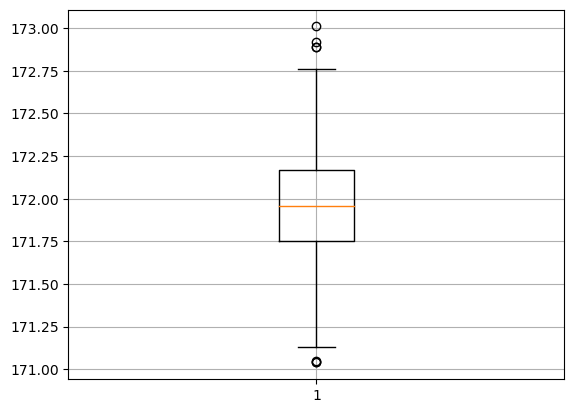

In [6]:
# diagonal

plt.boxplot(billets['diagonal'])
plt.grid()

plt.show()

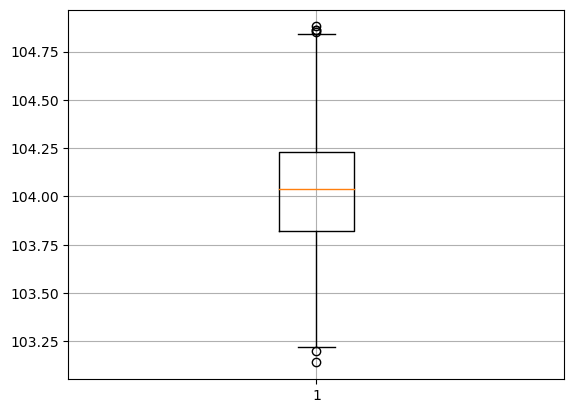

In [7]:
# height_left

plt.boxplot(billets['height_left'])
plt.grid()

plt.show()

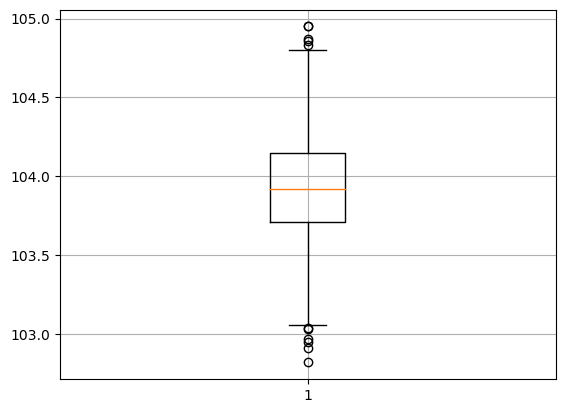

In [8]:
# height_right

plt.boxplot(billets['height_right'])
plt.grid()

plt.show()

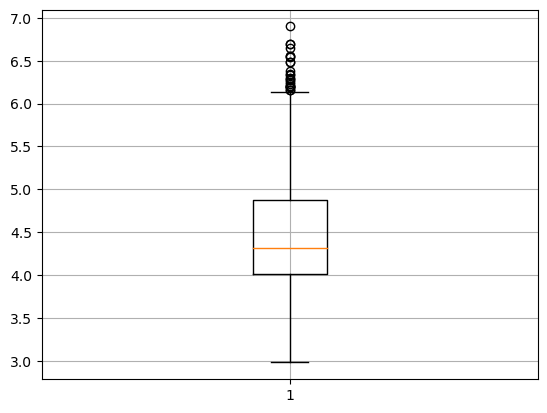

In [9]:
# margin_low

plt.boxplot(billets['margin_low'].dropna())
plt.grid()

plt.show()

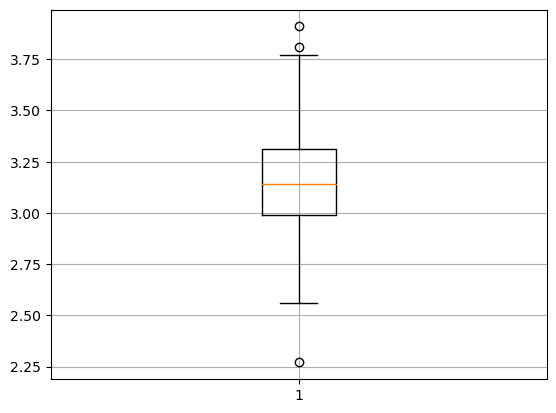

In [10]:
# margin_up

plt.boxplot(billets['margin_up'])
plt.grid()

plt.show()

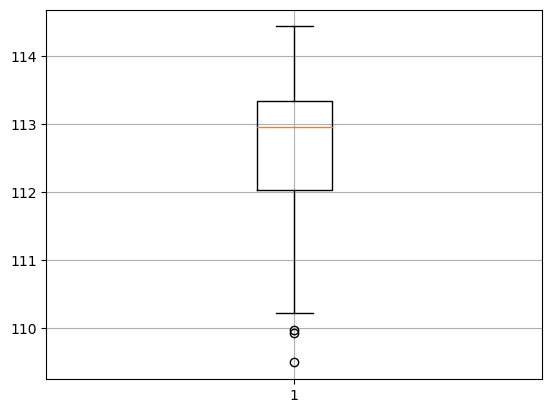

In [11]:
# length

plt.boxplot(billets['length'])
plt.grid()

plt.show()

# 1.2. Analyse des valeurs manquantes

In [12]:
# Décompte des valeurs manquantes
billets.isnull().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

In [13]:
# Détail des valeurs manquantes
billets.loc[billets['margin_low'].isna()]

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
72          True    171.94       103.89        103.45         NaN       3.25   
99          True    171.93       104.07        104.18         NaN       3.14   
151         True    172.07       103.80        104.38         NaN       3.02   
197         True    171.45       103.66        103.80         NaN       3.62   
241         True    171.83       104.14        104.06         NaN       3.02   
251         True    171.80       103.26        102.82         NaN       2.95   
284         True    171.92       103.83        103.76         NaN       3.23   
334         True    171.85       103.70        103.96         NaN       3.00   
410         True    172.56       103.72        103.51         NaN       3.12   
413         True    172.30       103.66        103.50         NaN       3.16   
445         True    172.34       104.42        103.22         NaN       3.01   
481         True    171.81       103.53        103.96         NaN       2.71   
505         True    172.01       103.97        104.05         NaN       2.98   
611         True    171.80       103.68        103.49         NaN       3.30   
654         True    171.97       103.69        103.54         NaN       2.70   
675         True    171.60       103.85        103.91         NaN       2.56   
710         True    172.03       103.97        103.86         NaN       3.07   
739         True    172.07       103.74        103.76         NaN       3.09   
742         True    172.14       104.06        103.96         NaN       3.24   
780         True    172.41       103.95        103.79         NaN       3.13   
798         True    171.96       103.84        103.62         NaN       3.01   
844         True    171.62       104.14        104.49         NaN       2.99   
845         True    172.02       104.21        104.05         NaN       2.90   
871         True    171.37       104.07        103.75         NaN       3.07   
895         True    171.81       103.68        103.80         NaN       2.98   
919         True    171.92       103.68        103.45         NaN       2.58   
945         True    172.09       103.74        103.52         NaN       3.02   
946         True    171.63       103.87        104.66         NaN       3.27   
981         True    172.02       104.23        103.72         NaN       2.99   
1076       False    171.57       104.27        104.44         NaN       3.21   
1121       False    171.40       104.38        104.19         NaN       3.17   
1176       False    171.59       104.05        103.94         NaN       3.02   
1303       False    172.17       104.49        103.76         NaN       2.93   
1315       False    172.08       104.15        104.17         NaN       3.40   
1347       False    171.72       104.46        104.12         NaN       3.61   
1435       False    172.66       104.33        104.41         NaN       3.56   
1438       False    171.90       104.28        104.29         NaN       3.24   

      length  
72    112.79  
99    113.08  
151   112.93  
197   113.27  
241   112.36  
251   113.22  
284   113.29  
334   113.36  
410   112.95  
413   112.95  
445   112.97  
481   113.99  
505   113.65  
611   112.84  
654   112.79  
675   113.27  
710   112.65  
739   112.41  
742   113.07  
780   113.41  
798   114.44  
844   113.35  
845   113.62  
871   113.27  
895   113.82  
919   113.68  
945   112.78  
946   112.68  
981   113.37  
1076  111.87  
1121  112.39  
1176  111.29  
1303  111.21  
1315  112.29  
1347  110.31  
1435  111.47  
1438  111.49

# 1.2.1 Imputation par régression linéaire

In [14]:
# création d'un df faux billet et d'un df vrai billets

faux_billets = billets.loc[billets['is_genuine'] == False]
faux_billets = faux_billets.drop('is_genuine', axis = 1)

vrais_billets = billets.loc[billets['is_genuine'] == True]
vrais_billets = vrais_billets.drop('is_genuine', axis = 1)


print("Tableau des faux billets")
display(faux_billets.head())
print(faux_billets.shape)
print("________________________________________________________")
print()
print("Tableau des vrais billets")
display(vrais_billets.head())
print(vrais_billets.shape)

Tableau des faux billets


diagonal  height_left  height_right  margin_low  margin_up  length
1000    172.28       103.95        103.91        4.78       3.31  111.40
1001    171.92       103.86        104.30        4.96       3.13  111.29
1002    171.59       104.14        104.38        4.97       3.47  111.22
1003    172.02       104.33        104.33        5.19       3.21  111.99
1004    172.55       104.25        104.23        5.60       3.13  111.72

(500, 6)
________________________________________________________

Tableau des vrais billets


diagonal  height_left  height_right  margin_low  margin_up  length
0    171.81       104.86        104.95        4.52       2.89  112.83
1    171.46       103.36        103.66        3.77       2.99  113.09
2    172.69       104.48        103.50        4.40       2.94  113.16
3    171.36       103.91        103.94        3.62       3.01  113.51
4    171.73       104.28        103.46        4.04       3.48  112.54

(1000, 6)


Nous séparons les vrais des faux billets afin de réaliser une régression linéaire pour prévoir les valeurs manquantes de la colonne margin_low.

Nous allons retirer les valeurs manquantes dans chacun des deux tableaux. Puis séparer nos données en données d'entraînement et données de test avec le ratio de 80/20.

Nous commencerons par les vrais billets puis par les faux billets.

### Billets authentiques

In [15]:
# suppression des valeurs manquantes dans vrais_billets
vrais_billets = vrais_billets.dropna()
vrais_billets

diagonal  height_left  height_right  margin_low  margin_up  length
0      171.81       104.86        104.95        4.52       2.89  112.83
1      171.46       103.36        103.66        3.77       2.99  113.09
2      172.69       104.48        103.50        4.40       2.94  113.16
3      171.36       103.91        103.94        3.62       3.01  113.51
4      171.73       104.28        103.46        4.04       3.48  112.54
..        ...          ...           ...         ...        ...     ...
995    171.66       103.92        103.47        4.26       2.83  113.20
996    172.16       103.72        103.61        4.30       2.72  113.51
997    171.78       103.38        104.22        4.23       3.07  113.77
998    171.44       103.96        103.92        3.68       2.89  113.21
999    171.56       104.07        103.58        3.55       3.02  112.96

[971 rows x 6 columns]

In [16]:
# Séparation des variables indépendantes de la variable dépendante margin_low

Xvrai = vrais_billets.drop('margin_low', axis = 1)
yvrai = vrais_billets[['margin_low']]

# Séparation des données en données d'entraînement et données test 80/20

Xvrai_train, Xvrai_test, yvrai_train, yvrai_test = train_test_split(Xvrai, yvrai, test_size=0.2, random_state=42)

print('train set :', Xvrai_train.shape)
print('test set :', Xvrai_test.shape)

train set : (776, 5)
test set : (195, 5)


In [17]:
# Initiation d'un objet pour la régression et entraînement du modèle sur les données train

model = LinearRegression()

model.fit(Xvrai_train, yvrai_train)

LinearRegression()

In [18]:
# Vérifions le coefficient de détermination R²
print('train score:', model.score(Xvrai_train, yvrai_train))
print('test score:', model.score(Xvrai_test, yvrai_test))

train score: 0.013719517218425126
test score: -0.01874712913393517


In [19]:
# Calcul du root mean squared error sur les données test
from sklearn.metrics import mean_squared_error

# Prédiction sur les données de test
yvrai_pred = model.predict(Xvrai_test)
# Calcul du RMSE sur les données de test
rmse = mean_squared_error(yvrai_test, yvrai_pred, squared=False)
print('RMSE: ',rmse)

RMSE:  0.32418937293126215


In [20]:
# Utilisation de la bibliothèque statsmodels pour régression sur les vrais billets

reg_vrais = smf.ols('margin_low~diagonal+height_left+height_right+margin_up+length', data = vrais_billets).fit()

print(reg_vrais.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.544
Date:                Mon, 14 Aug 2023   Prob (F-statistic):              0.174
Time:                        16:16:54   Log-Likelihood:                -264.37
No. Observations:                 971   AIC:                             540.7
Df Residuals:                     965   BIC:                             570.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -10.4144      7.928     -1.314   

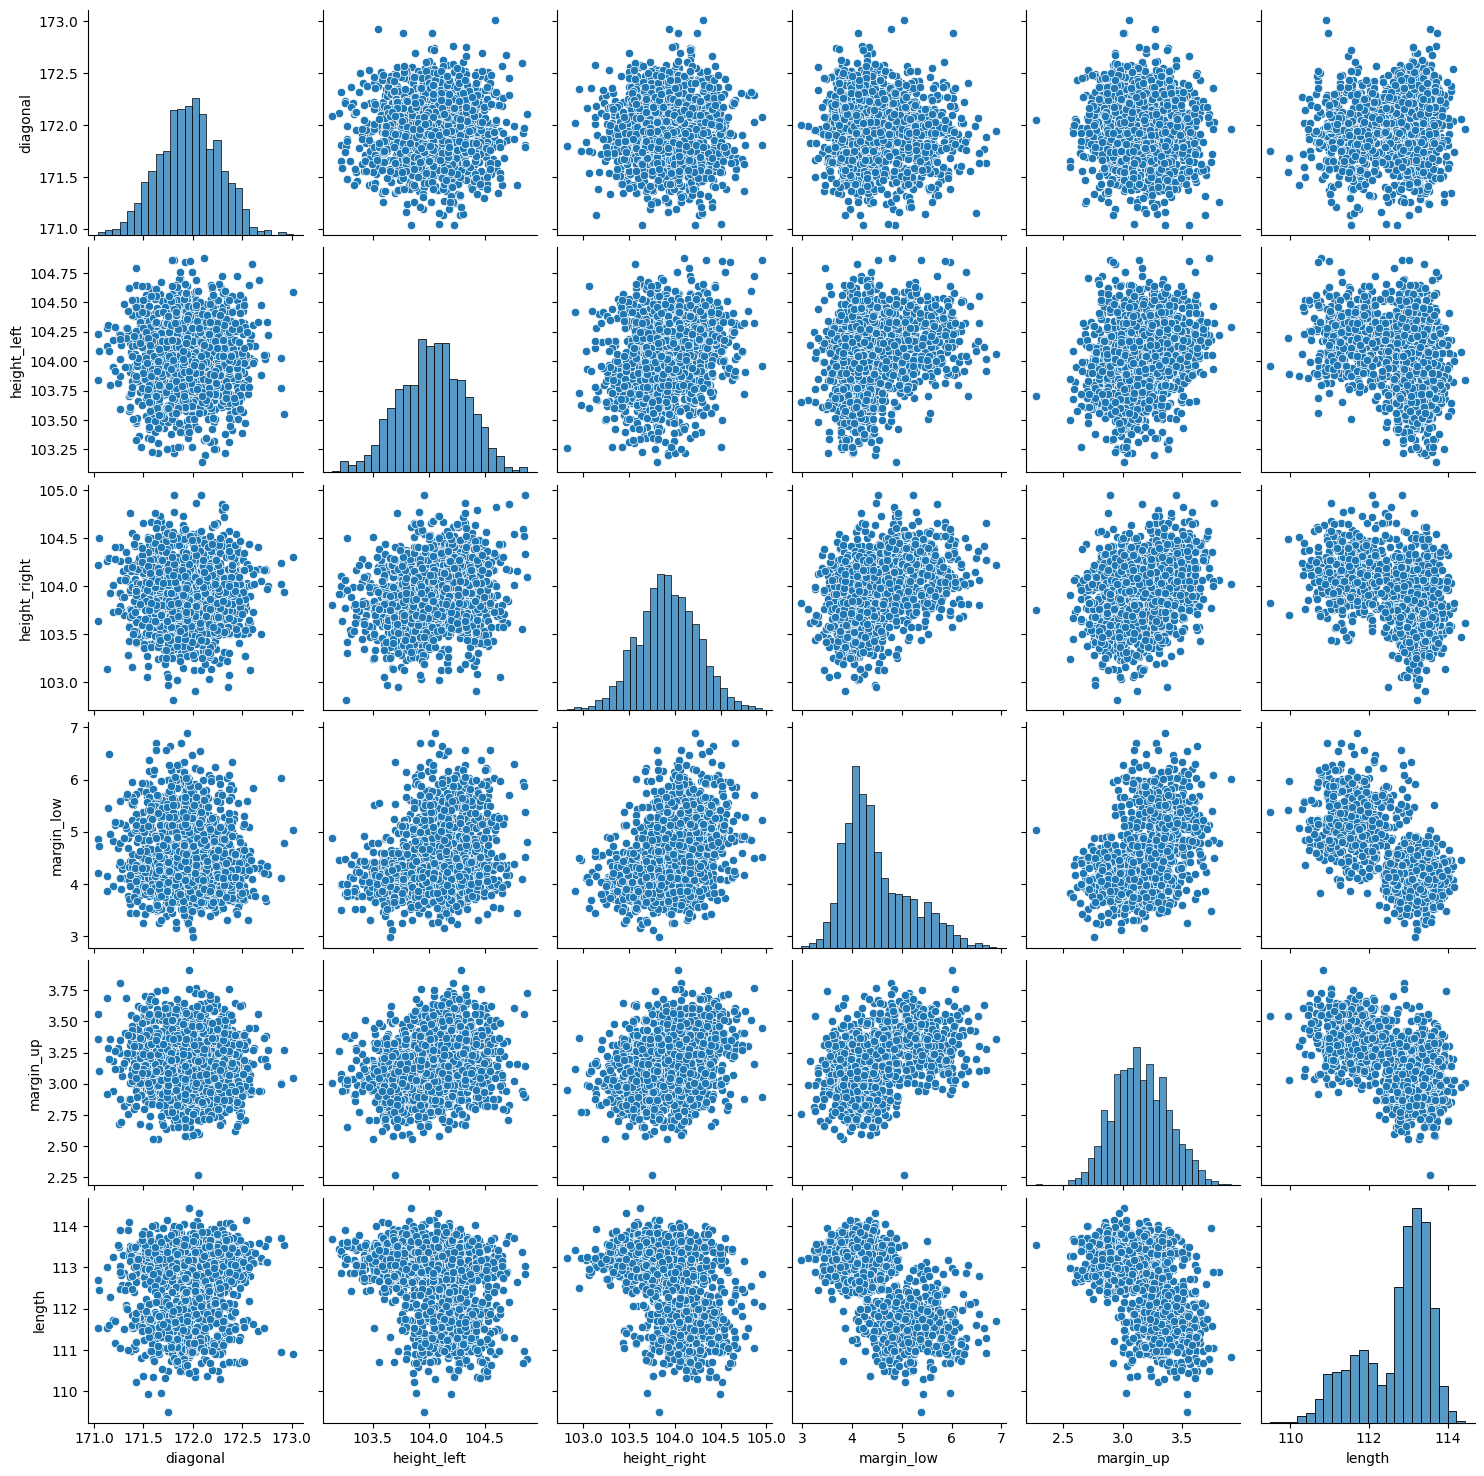

In [21]:
columns = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']

# Sélectionner les colonnes nécessaires pour l'analyse
data_for_pairplot = billets[columns]

# Utiliser la fonction pairplot pour afficher les scatterplots
sns.pairplot(data_for_pairplot)

plt.show()

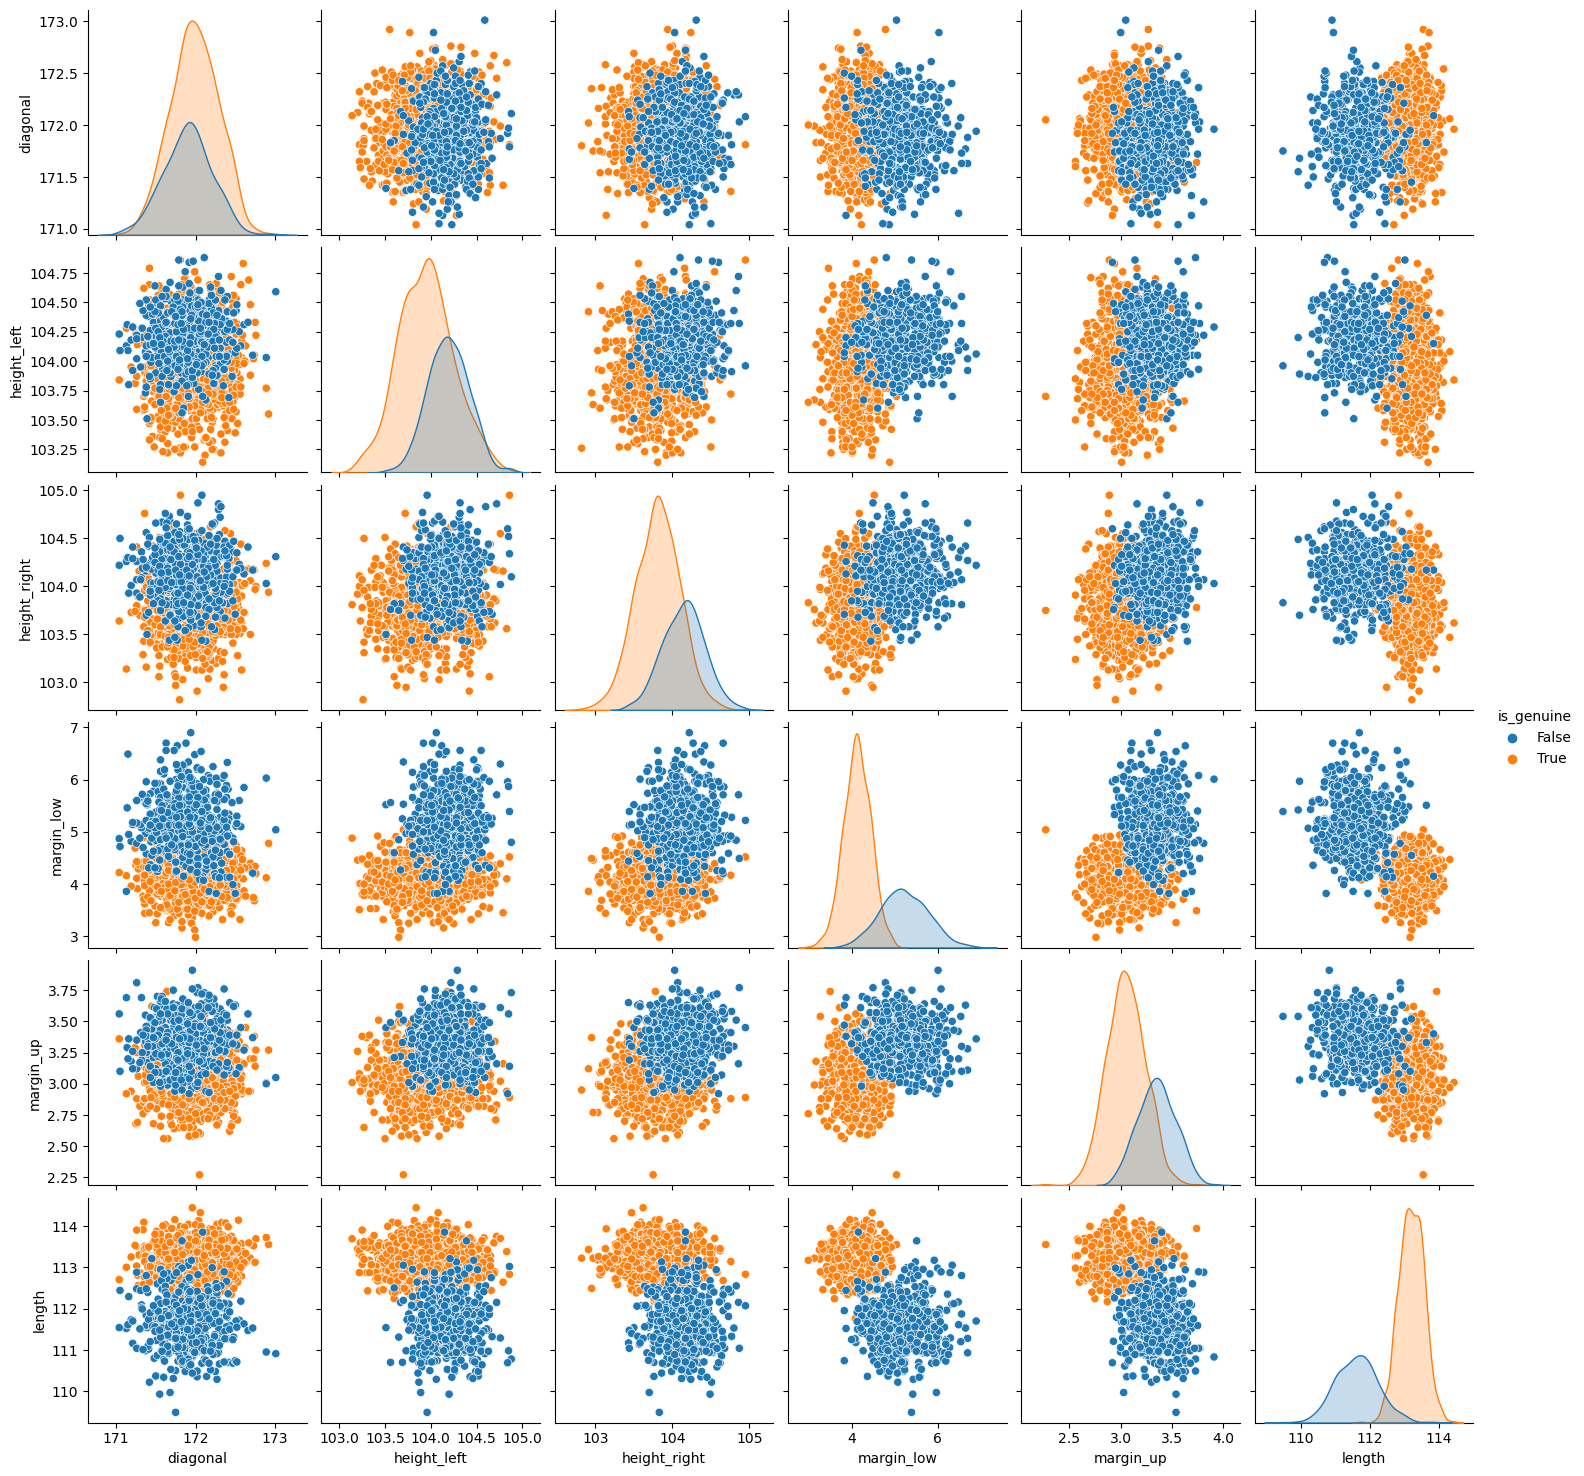

In [22]:
columns = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']

data_for_pairplot = billets[columns].copy()

data_for_pairplot['is_genuine'] = billets['is_genuine']

# Utiliser la fonction pairplot pour afficher les scatterplots avec hue='is_genuine'
sns.pairplot(data_for_pairplot, hue='is_genuine')

plt.show()

In [23]:
# On récupère les observations des vrais billets sans la colonne is_genuine 
vrais_billets = billets.loc[billets['is_genuine'] == True]
vrais_billets = vrais_billets.drop('is_genuine', axis = 1)

# Récupération des valeurs des variables indépendantes
Xvrai_pred = vrais_billets[vrais_billets['margin_low'].isna()]
Xvrai_pred = Xvrai_pred.drop('margin_low', axis = 1)
Xvrai_pred

diagonal  height_left  height_right  margin_up  length
72     171.94       103.89        103.45       3.25  112.79
99     171.93       104.07        104.18       3.14  113.08
151    172.07       103.80        104.38       3.02  112.93
197    171.45       103.66        103.80       3.62  113.27
241    171.83       104.14        104.06       3.02  112.36
251    171.80       103.26        102.82       2.95  113.22
284    171.92       103.83        103.76       3.23  113.29
334    171.85       103.70        103.96       3.00  113.36
410    172.56       103.72        103.51       3.12  112.95
413    172.30       103.66        103.50       3.16  112.95
445    172.34       104.42        103.22       3.01  112.97
481    171.81       103.53        103.96       2.71  113.99
505    172.01       103.97        104.05       2.98  113.65
611    171.80       103.68        103.49       3.30  112.84
654    171.97       103.69        103.54       2.70  112.79
675    171.60       103.85        103.91       2.56  113.27
710    172.03       103.97        103.86       3.07  112.65
739    172.07       103.74        103.76       3.09  112.41
742    172.14       104.06        103.96       3.24  113.07
780    172.41       103.95        103.79       3.13  113.41
798    171.96       103.84        103.62       3.01  114.44
844    171.62       104.14        104.49       2.99  113.35
845    172.02       104.21        104.05       2.90  113.62
871    171.37       104.07        103.75       3.07  113.27
895    171.81       103.68        103.80       2.98  113.82
919    171.92       103.68        103.45       2.58  113.68
945    172.09       103.74        103.52       3.02  112.78
946    171.63       103.87        104.66       3.27  112.68
981    172.02       104.23        103.72       2.99  113.37

In [24]:
# Prédiction des valeurs des nan de la colonne margin_low grâce au modèle de régression linéaire
yvrai_pred = model.predict(Xvrai_pred)
yvrai_pred

array([[4.05232966],
       [4.10973025],
       [4.13105225],
       [4.00741244],
       [4.08447882],
       [4.08097867],
       [4.08861849],
       [4.12799885],
       [4.10924004],
       [4.08983455],
       [4.11300151],
       [4.19693431],
       [4.15866697],
       [4.03979211],
       [4.13541538],
       [4.17596754],
       [4.09175799],
       [4.07320984],
       [4.09680482],
       [4.1350217 ],
       [4.17306151],
       [4.14146993],
       [4.17203584],
       [4.08683203],
       [4.14515805],
       [4.18995547],
       [4.09365352],
       [4.07190351],
       [4.13536466]])

In [25]:
# On récupère les index des nan pour l'imputation
nan_indexes = vrais_billets[vrais_billets['margin_low'].isna()].index

# Transformation de yvrai_pred en un array 1D
yvrai_pred = np.array(yvrai_pred).ravel()

# Imputation des valeurs prédites grâce aux index
vrais_billets.loc[nan_indexes, 'margin_low'] = yvrai_pred

vrais_billets.isna().sum()

diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

In [26]:
# Retour de la colonne is_genuine
vrais_billets['is_genuine'] = True
vrais_billets

diagonal  height_left  height_right  margin_low  margin_up  length  \
0      171.81       104.86        104.95        4.52       2.89  112.83   
1      171.46       103.36        103.66        3.77       2.99  113.09   
2      172.69       104.48        103.50        4.40       2.94  113.16   
3      171.36       103.91        103.94        3.62       3.01  113.51   
4      171.73       104.28        103.46        4.04       3.48  112.54   
..        ...          ...           ...         ...        ...     ...   
995    171.66       103.92        103.47        4.26       2.83  113.20   
996    172.16       103.72        103.61        4.30       2.72  113.51   
997    171.78       103.38        104.22        4.23       3.07  113.77   
998    171.44       103.96        103.92        3.68       2.89  113.21   
999    171.56       104.07        103.58        3.55       3.02  112.96   

     is_genuine  
0          True  
1          True  
2          True  
3          True  
4          True  
..          ...  
995        True  
996        True  
997        True  
998        True  
999        True  

[1000 rows x 7 columns]

### Faux billets

In [27]:
# suppression des valeurs manquantes dans faux_billets
faux_billets = faux_billets.dropna()
faux_billets

diagonal  height_left  height_right  margin_low  margin_up  length
1000    172.28       103.95        103.91        4.78       3.31  111.40
1001    171.92       103.86        104.30        4.96       3.13  111.29
1002    171.59       104.14        104.38        4.97       3.47  111.22
1003    172.02       104.33        104.33        5.19       3.21  111.99
1004    172.55       104.25        104.23        5.60       3.13  111.72
...        ...          ...           ...         ...        ...     ...
1495    171.75       104.38        104.17        4.42       3.09  111.28
1496    172.19       104.63        104.44        5.27       3.37  110.97
1497    171.80       104.01        104.12        5.51       3.36  111.95
1498    172.06       104.28        104.06        5.17       3.46  112.25
1499    171.47       104.15        103.82        4.63       3.37  112.07

[492 rows x 6 columns]

In [28]:
# Séparation des variables indépendante de la variable dépendante margin_low

Xfaux = faux_billets.drop('margin_low', axis = 1)
yfaux = faux_billets[['margin_low']]

# Séparation des données en données d'entraînement et données test 80/20

Xfaux_train, Xfaux_test, yfaux_train, yfaux_test = train_test_split(Xfaux, yfaux, test_size=0.2, random_state=42)

print('train set :', Xfaux_train.shape)
print('test set :', Xfaux_test.shape)

train set : (393, 5)
test set : (99, 5)


In [29]:
# Initiation d'un objet pour la régression et entraînement du modèle sur les données train

model = LinearRegression()

model.fit(Xfaux_train, yfaux_train)

LinearRegression()

In [30]:
# Calcul du coefficient de détermination R²
print('train score:', model.score(Xfaux_train, yfaux_train))
print('test score:', model.score(Xfaux_test, yfaux_test))

train score: 0.03624938405511202
test score: -0.026769492279266505


In [31]:
from sklearn.metrics import mean_squared_error

# Prédiction sur les données de test
yfaux_pred = model.predict(Xfaux_test)
# Calcul du RMSE sur les données de test
rmse = mean_squared_error(yfaux_test, yfaux_pred, squared=False)
print('RMSE: ',rmse)

RMSE:  0.5264504654625001


In [32]:
# On récupère les observations des faux billets sans la colonne is_genuine 
faux_billets = billets.loc[billets['is_genuine'] == False]
faux_billets = faux_billets.drop('is_genuine', axis = 1)

# Récupération des valeurs des variables indépendantes
Xfaux_pred = faux_billets[faux_billets['margin_low'].isna()]
Xfaux_pred = Xfaux_pred.drop('margin_low', axis = 1)
Xfaux_pred

diagonal  height_left  height_right  margin_up  length
1076    171.57       104.27        104.44       3.21  111.87
1121    171.40       104.38        104.19       3.17  112.39
1176    171.59       104.05        103.94       3.02  111.29
1303    172.17       104.49        103.76       2.93  111.21
1315    172.08       104.15        104.17       3.40  112.29
1347    171.72       104.46        104.12       3.61  110.31
1435    172.66       104.33        104.41       3.56  111.47
1438    171.90       104.28        104.29       3.24  111.49

In [33]:
# Prédiction des valeurs des nan de la colonne margin_low grâce à au modèle de régression
yfaux_pred = model.predict(Xfaux_pred)
yfaux_pred

array([[5.34543533],
       [5.35568618],
       [5.42393359],
       [5.4225345 ],
       [5.12882567],
       [5.20459907],
       [5.04206843],
       [5.29792276]])

In [34]:
# On récupère les index des nan pour l'imputation
nan_index = faux_billets[faux_billets['margin_low'].isna()].index

# Transformation de yvrai_pred en un array 1D
yfaux_pred = np.array(yfaux_pred).ravel()

# Imputation des valeurs prédites grâce aux index
faux_billets.loc[nan_index, 'margin_low'] = yfaux_pred

faux_billets.isna().sum()

diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

In [35]:
# Retour de la colonne is_genuine
faux_billets['is_genuine'] = False
faux_billets

diagonal  height_left  height_right  margin_low  margin_up  length  \
1000    172.28       103.95        103.91        4.78       3.31  111.40   
1001    171.92       103.86        104.30        4.96       3.13  111.29   
1002    171.59       104.14        104.38        4.97       3.47  111.22   
1003    172.02       104.33        104.33        5.19       3.21  111.99   
1004    172.55       104.25        104.23        5.60       3.13  111.72   
...        ...          ...           ...         ...        ...     ...   
1495    171.75       104.38        104.17        4.42       3.09  111.28   
1496    172.19       104.63        104.44        5.27       3.37  110.97   
1497    171.80       104.01        104.12        5.51       3.36  111.95   
1498    172.06       104.28        104.06        5.17       3.46  112.25   
1499    171.47       104.15        103.82        4.63       3.37  112.07   

      is_genuine  
1000       False  
1001       False  
1002       False  
1003       False  
1004       False  
...          ...  
1495       False  
1496       False  
1497       False  
1498       False  
1499       False  

[500 rows x 7 columns]

In [36]:
# On rassemble les DF vrai et faux
billets_reg_lin = pd.concat([vrais_billets, faux_billets])
billets_reg_lin

diagonal  height_left  height_right  margin_low  margin_up  length  \
0       171.81       104.86        104.95        4.52       2.89  112.83   
1       171.46       103.36        103.66        3.77       2.99  113.09   
2       172.69       104.48        103.50        4.40       2.94  113.16   
3       171.36       103.91        103.94        3.62       3.01  113.51   
4       171.73       104.28        103.46        4.04       3.48  112.54   
...        ...          ...           ...         ...        ...     ...   
1495    171.75       104.38        104.17        4.42       3.09  111.28   
1496    172.19       104.63        104.44        5.27       3.37  110.97   
1497    171.80       104.01        104.12        5.51       3.36  111.95   
1498    172.06       104.28        104.06        5.17       3.46  112.25   
1499    171.47       104.15        103.82        4.63       3.37  112.07   

      is_genuine  
0           True  
1           True  
2           True  
3           True  
4           True  
...          ...  
1495       False  
1496       False  
1497       False  
1498       False  
1499       False  

[1500 rows x 7 columns]

In [37]:
X = billets_reg_lin.drop('is_genuine', axis=1)
y = billets_reg_lin[['is_genuine']]

# Ajout d'une colonne de constante pour la régression linéaire
X = sm.add_constant(X)

# Instanciation du modèle de régression linéaire
linear_model = sm.OLS(y, X)

# Ajustement du modèle
results = linear_model.fit()

### Colinéarité des variables

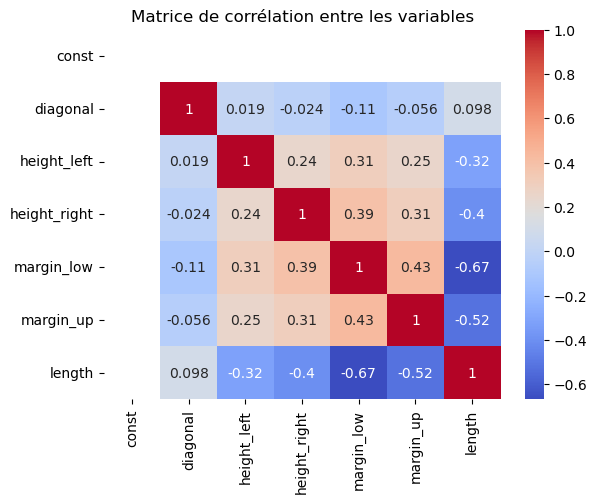

In [38]:
# Matrice de corrélation
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Matrice de corrélation entre les variables")
plt.show()

In [39]:
# Calcul du variance inflation factor pour chacune des variables

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calcul du VIF pour chaque variable
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# DataFrame pour afficher les valeurs VIF pour chaque variable
vif_df = pd.DataFrame({'Variable': X.columns, 'VIF': vif})

print(vif_df)

       Variable            VIF
0         const  593856.418127
1      diagonal       1.017991
2   height_left       1.159112
3  height_right       1.259376
4    margin_low       1.920523
5     margin_up       1.417417
6        length       2.137845


### Homoscédasticité

In [40]:
import statsmodels.stats.api as sms

# Calculer les résidus
residuals = results.resid

# Effectuer le test de Breusch-Pagan
bp_test = sms.het_breuschpagan(residuals, X)

# Récupérer les p-values du test
p_value = bp_test[1]

# Afficher le résultat
print('p-value du test de Breusch-Pagan :', p_value)

p-value du test de Breusch-Pagan : 5.534663320570753e-18


Le test de Breusch-Pagan affiche une p-value bien inférieure au seuil de 0.05.Nous rejetons donc l'hypothèse H0 d'homoscédasticité.

### Normalité des résidus

In [41]:
shapiro(results.resid)

ShapiroResult(statistic=0.9887712001800537, pvalue=2.369408891311764e-09)

Le test de shapiro-Wilk affiche une p-value inférieure au seuil de 0.05. Nous rejetons donc l'hypothèse H0 de normalité des résidus.

Nous allons essayer la méthode du KNRegressor.

# 1.2.2 Imputation par la méthode du KNeighborsRegressor

In [42]:
# création d'un df faux billet et d'un df vrai billets

faux_billets = billets.loc[billets['is_genuine'] == False]
faux_billets = faux_billets.drop('is_genuine', axis = 1)

vrais_billets = billets.loc[billets['is_genuine'] == True]
vrais_billets = vrais_billets.drop('is_genuine', axis = 1)


print("Tableau des faux billets")
display(faux_billets.head())
print(faux_billets.shape)
print("________________________________________________________")
print()
print("Tableau des vrais billets")
display(vrais_billets.head())
print(vrais_billets.shape)

Tableau des faux billets


diagonal  height_left  height_right  margin_low  margin_up  length
1000    172.28       103.95        103.91        4.78       3.31  111.40
1001    171.92       103.86        104.30        4.96       3.13  111.29
1002    171.59       104.14        104.38        4.97       3.47  111.22
1003    172.02       104.33        104.33        5.19       3.21  111.99
1004    172.55       104.25        104.23        5.60       3.13  111.72

(500, 6)
________________________________________________________

Tableau des vrais billets


diagonal  height_left  height_right  margin_low  margin_up  length
0    171.81       104.86        104.95        4.52       2.89  112.83
1    171.46       103.36        103.66        3.77       2.99  113.09
2    172.69       104.48        103.50        4.40       2.94  113.16
3    171.36       103.91        103.94        3.62       3.01  113.51
4    171.73       104.28        103.46        4.04       3.48  112.54

(1000, 6)


## Billets authentiques

In [43]:
# suppression des valeurs manquantes dans vrais_billets
vrais_billets = vrais_billets.dropna()
vrais_billets

diagonal  height_left  height_right  margin_low  margin_up  length
0      171.81       104.86        104.95        4.52       2.89  112.83
1      171.46       103.36        103.66        3.77       2.99  113.09
2      172.69       104.48        103.50        4.40       2.94  113.16
3      171.36       103.91        103.94        3.62       3.01  113.51
4      171.73       104.28        103.46        4.04       3.48  112.54
..        ...          ...           ...         ...        ...     ...
995    171.66       103.92        103.47        4.26       2.83  113.20
996    172.16       103.72        103.61        4.30       2.72  113.51
997    171.78       103.38        104.22        4.23       3.07  113.77
998    171.44       103.96        103.92        3.68       2.89  113.21
999    171.56       104.07        103.58        3.55       3.02  112.96

[971 rows x 6 columns]

In [44]:
# Séparation des variables indépendantes de la variable dépendante margin_low

Xvrai = vrais_billets.drop('margin_low', axis = 1)
yvrai = vrais_billets[['margin_low']]

# Séparation des données en données d'entraînement et données test 80/20

Xvrai_train, Xvrai_test, yvrai_train, yvrai_test = train_test_split(Xvrai, yvrai, test_size=0.2, random_state=42)

print('train set :', Xvrai_train.shape)
print('test set :', Xvrai_test.shape)

train set : (776, 5)
test set : (195, 5)


In [45]:
# Normalisation des données
std_scaler = StandardScaler()
Xvrai_train = std_scaler.fit_transform(Xvrai_train)
Xvrai_test = std_scaler.transform(Xvrai_test)

# Grille de paramètres à tester
param_grid = {
    'n_neighbors': np.arange(1, 50), # Tester les valeurs de k de 1 à 50
    'weights': ['uniform', 'distance'],  # Tester les deux types de poids
    'p': [1, 2]  # Tester les distances de Manhattan (1) et Euclidienne (2)
}

grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='neg_root_mean_squared_error')

# Entraînement du modèle avec la recherche de grille
grid_search.fit(Xvrai_train, yvrai_train)

print("Meilleurs paramètres :", grid_search.best_params_)

print("Meilleur RMSE :", grid_search.best_score_)

Meilleurs paramètres : {'n_neighbors': 46, 'p': 2, 'weights': 'distance'}
Meilleur RMSE : -0.32198602070484006


In [46]:
# Récupération du modèle avec les meilleurs paramètres
model = grid_search.best_estimator_

# Prédictions sur les données test
yvrai_pred = model.predict(Xvrai_test)

# Calcul du RMSE
rmse = mean_squared_error(yvrai_test, yvrai_pred, squared=False)

print("Meilleur RMSE :", rmse)

Meilleur RMSE : 0.3285087150670587


In [47]:
# On récupère les observations des vrais billets sans la colonne is_genuine 
vrais_billets = billets.loc[billets['is_genuine'] == True]
vrais_billets = vrais_billets.drop('is_genuine', axis = 1)

# Récupération des valeurs des variables indépendantes
Xvrai_pred = vrais_billets[vrais_billets['margin_low'].isna()]
Xvrai_pred = Xvrai_pred.drop('margin_low', axis = 1)
Xvrai_pred

diagonal  height_left  height_right  margin_up  length
72     171.94       103.89        103.45       3.25  112.79
99     171.93       104.07        104.18       3.14  113.08
151    172.07       103.80        104.38       3.02  112.93
197    171.45       103.66        103.80       3.62  113.27
241    171.83       104.14        104.06       3.02  112.36
251    171.80       103.26        102.82       2.95  113.22
284    171.92       103.83        103.76       3.23  113.29
334    171.85       103.70        103.96       3.00  113.36
410    172.56       103.72        103.51       3.12  112.95
413    172.30       103.66        103.50       3.16  112.95
445    172.34       104.42        103.22       3.01  112.97
481    171.81       103.53        103.96       2.71  113.99
505    172.01       103.97        104.05       2.98  113.65
611    171.80       103.68        103.49       3.30  112.84
654    171.97       103.69        103.54       2.70  112.79
675    171.60       103.85        103.91       2.56  113.27
710    172.03       103.97        103.86       3.07  112.65
739    172.07       103.74        103.76       3.09  112.41
742    172.14       104.06        103.96       3.24  113.07
780    172.41       103.95        103.79       3.13  113.41
798    171.96       103.84        103.62       3.01  114.44
844    171.62       104.14        104.49       2.99  113.35
845    172.02       104.21        104.05       2.90  113.62
871    171.37       104.07        103.75       3.07  113.27
895    171.81       103.68        103.80       2.98  113.82
919    171.92       103.68        103.45       2.58  113.68
945    172.09       103.74        103.52       3.02  112.78
946    171.63       103.87        104.66       3.27  112.68
981    172.02       104.23        103.72       2.99  113.37

In [48]:
# Prédiction des valeurs des nan de la colonne margin_low grâce au modèle KNR
yvrai_pred = model.predict(Xvrai_pred)
yvrai_pred

C:\Users\sebhe\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(


array([[4.12044914],
       [4.12044961],
       [4.12044935],
       [4.12044888],
       [4.12045007],
       [4.12044834],
       [4.12044903],
       [4.12044915],
       [4.12044848],
       [4.12044858],
       [4.12044957],
       [4.120449  ],
       [4.12044932],
       [4.12044893],
       [4.12044934],
       [4.12044993],
       [4.12044949],
       [4.12044918],
       [4.12044927],
       [4.12044884],
       [4.12044878],
       [4.12045009],
       [4.1204497 ],
       [4.12044993],
       [4.12044897],
       [4.12044915],
       [4.12044903],
       [4.12044976],
       [4.12044963]])

In [49]:
# On récupère les index des nan pour l'imputation
nan_indexes = vrais_billets[vrais_billets['margin_low'].isna()].index

# Transformation de yvrai_pred en un array 1D
yvrai_pred = np.array(yvrai_pred).ravel()

# Imputation des valeurs prédites grâce aux index
vrais_billets.loc[nan_indexes, 'margin_low'] = yvrai_pred

vrais_billets.isna().sum()

diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

In [50]:
# Retour de la colonne is_genuine
vrais_billets['is_genuine'] = True
vrais_billets

diagonal  height_left  height_right  margin_low  margin_up  length  \
0      171.81       104.86        104.95        4.52       2.89  112.83   
1      171.46       103.36        103.66        3.77       2.99  113.09   
2      172.69       104.48        103.50        4.40       2.94  113.16   
3      171.36       103.91        103.94        3.62       3.01  113.51   
4      171.73       104.28        103.46        4.04       3.48  112.54   
..        ...          ...           ...         ...        ...     ...   
995    171.66       103.92        103.47        4.26       2.83  113.20   
996    172.16       103.72        103.61        4.30       2.72  113.51   
997    171.78       103.38        104.22        4.23       3.07  113.77   
998    171.44       103.96        103.92        3.68       2.89  113.21   
999    171.56       104.07        103.58        3.55       3.02  112.96   

     is_genuine  
0          True  
1          True  
2          True  
3          True  
4          True  
..          ...  
995        True  
996        True  
997        True  
998        True  
999        True  

[1000 rows x 7 columns]

## Faux billets

In [51]:
# suppression des valeurs manquantes dans faux_billets
faux_billets = faux_billets.dropna()
faux_billets

diagonal  height_left  height_right  margin_low  margin_up  length
1000    172.28       103.95        103.91        4.78       3.31  111.40
1001    171.92       103.86        104.30        4.96       3.13  111.29
1002    171.59       104.14        104.38        4.97       3.47  111.22
1003    172.02       104.33        104.33        5.19       3.21  111.99
1004    172.55       104.25        104.23        5.60       3.13  111.72
...        ...          ...           ...         ...        ...     ...
1495    171.75       104.38        104.17        4.42       3.09  111.28
1496    172.19       104.63        104.44        5.27       3.37  110.97
1497    171.80       104.01        104.12        5.51       3.36  111.95
1498    172.06       104.28        104.06        5.17       3.46  112.25
1499    171.47       104.15        103.82        4.63       3.37  112.07

[492 rows x 6 columns]

In [52]:
# Séparation des variables indépendante de la variable dépendante margin_low

Xfaux = faux_billets.drop('margin_low', axis = 1)
yfaux = faux_billets[['margin_low']]

# Séparation des données en données d'entraînement et données test 80/20

Xfaux_train, Xfaux_test, yfaux_train, yfaux_test = train_test_split(Xfaux, yfaux, test_size=0.2, random_state=42)

print('train set :', Xfaux_train.shape)
print('test set :', Xfaux_test.shape)

train set : (393, 5)
test set : (99, 5)


In [53]:
# Grille de paramètres à tester
param_grid = {
    'n_neighbors': np.arange(1, 50), # Tester les valeurs de k de 1 à 50
    'weights': ['uniform', 'distance'],  # Tester les deux types de poids
    'p': [1, 2]  # Tester les distances de Manhattan (1) et Euclidienne (2)
}

grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='neg_root_mean_squared_error')

# Entraînement du modèle avec la recherche de grille
grid_search.fit(Xfaux_train, yfaux_train)

print("Meilleurs paramètres :", grid_search.best_params_)

print("Meilleur RMSE :", grid_search.best_score_)

Meilleurs paramètres : {'n_neighbors': 47, 'p': 1, 'weights': 'uniform'}
Meilleur RMSE : -0.5641295470937763


In [54]:
# Récupération du meilleur modèle
model = grid_search.best_estimator_

# Prédictions sur l'ensemble de test
yfaux_pred = model.predict(Xfaux_test)

# Calcul du MSE
mse_faux = np.mean((yfaux_test - yfaux_pred)**2)

# Calcul de RMSE
rmse_faux = np.sqrt(mse_faux)

print("Meilleur RMSE :", rmse_faux)

Meilleur RMSE : margin_low    0.515481
dtype: float64


C:\Users\sebhe\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [55]:
# On récupère les observations des faux billets sans la colonne is_genuine 
faux_billets = billets.loc[billets['is_genuine'] == False]
faux_billets = faux_billets.drop('is_genuine', axis = 1)

# Récupération des valeurs des variables indépendantes
Xfaux_pred = faux_billets[faux_billets['margin_low'].isna()]
Xfaux_pred = Xfaux_pred.drop('margin_low', axis = 1)
Xfaux_pred

diagonal  height_left  height_right  margin_up  length
1076    171.57       104.27        104.44       3.21  111.87
1121    171.40       104.38        104.19       3.17  112.39
1176    171.59       104.05        103.94       3.02  111.29
1303    172.17       104.49        103.76       2.93  111.21
1315    172.08       104.15        104.17       3.40  112.29
1347    171.72       104.46        104.12       3.61  110.31
1435    172.66       104.33        104.41       3.56  111.47
1438    171.90       104.28        104.29       3.24  111.49

In [56]:
# Prédiction des valeurs des nan de la colonne margin_low grâce au modèle KNR
yfaux_pred = model.predict(Xfaux_pred)
yfaux_pred

array([[5.22170213],
       [5.33042553],
       [5.33978723],
       [5.19340426],
       [5.14446809],
       [5.22617021],
       [5.18574468],
       [5.23659574]])

In [57]:
# On récupère les index des nan pour l'imputation
nan_index = faux_billets[faux_billets['margin_low'].isna()].index

# Transformation de yvrai_pred en un array 1D
yfaux_pred = np.array(yfaux_pred).ravel()

# Imputation des valeurs prédites grâce aux index
faux_billets.loc[nan_index, 'margin_low'] = yfaux_pred

faux_billets.isna().sum()

diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

In [58]:
# Retour de la colonne is_genuine
faux_billets['is_genuine'] = False
faux_billets

diagonal  height_left  height_right  margin_low  margin_up  length  \
1000    172.28       103.95        103.91        4.78       3.31  111.40   
1001    171.92       103.86        104.30        4.96       3.13  111.29   
1002    171.59       104.14        104.38        4.97       3.47  111.22   
1003    172.02       104.33        104.33        5.19       3.21  111.99   
1004    172.55       104.25        104.23        5.60       3.13  111.72   
...        ...          ...           ...         ...        ...     ...   
1495    171.75       104.38        104.17        4.42       3.09  111.28   
1496    172.19       104.63        104.44        5.27       3.37  110.97   
1497    171.80       104.01        104.12        5.51       3.36  111.95   
1498    172.06       104.28        104.06        5.17       3.46  112.25   
1499    171.47       104.15        103.82        4.63       3.37  112.07   

      is_genuine  
1000       False  
1001       False  
1002       False  
1003       False  
1004       False  
...          ...  
1495       False  
1496       False  
1497       False  
1498       False  
1499       False  

[500 rows x 7 columns]

# 2. ANALYSE DESCRIPTIVE DES DONNEES

In [59]:
billets = pd.concat([vrais_billets, faux_billets])
billets

diagonal  height_left  height_right  margin_low  margin_up  length  \
0       171.81       104.86        104.95        4.52       2.89  112.83   
1       171.46       103.36        103.66        3.77       2.99  113.09   
2       172.69       104.48        103.50        4.40       2.94  113.16   
3       171.36       103.91        103.94        3.62       3.01  113.51   
4       171.73       104.28        103.46        4.04       3.48  112.54   
...        ...          ...           ...         ...        ...     ...   
1495    171.75       104.38        104.17        4.42       3.09  111.28   
1496    172.19       104.63        104.44        5.27       3.37  110.97   
1497    171.80       104.01        104.12        5.51       3.36  111.95   
1498    172.06       104.28        104.06        5.17       3.46  112.25   
1499    171.47       104.15        103.82        4.63       3.37  112.07   

      is_genuine  
0           True  
1           True  
2           True  
3           True  
4           True  
...          ...  
1495       False  
1496       False  
1497       False  
1498       False  
1499       False  

[1500 rows x 7 columns]

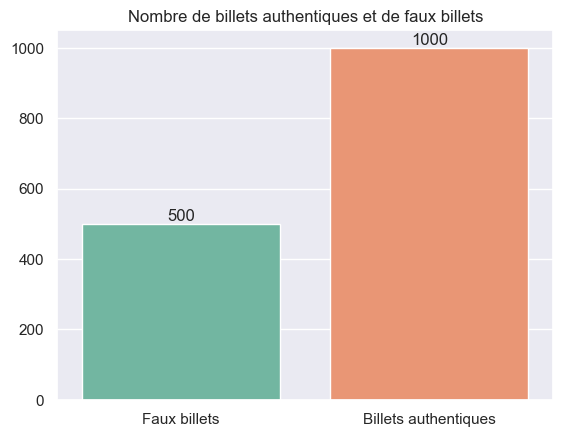

In [60]:
sns.set_theme()
sns.set_palette('Set2')

sns.barplot(x = ['Faux billets', 'Billets authentiques'], y = [len(faux_billets['is_genuine']), len(vrais_billets['is_genuine'])])
plt.title("Nombre de billets authentiques et de faux billets")

counts = [len(faux_billets['is_genuine']), len(vrais_billets['is_genuine'])]
for i in range(len(counts)):
    plt.text(i, counts[i], str(counts[i]), ha='center', va='bottom')


plt.show()

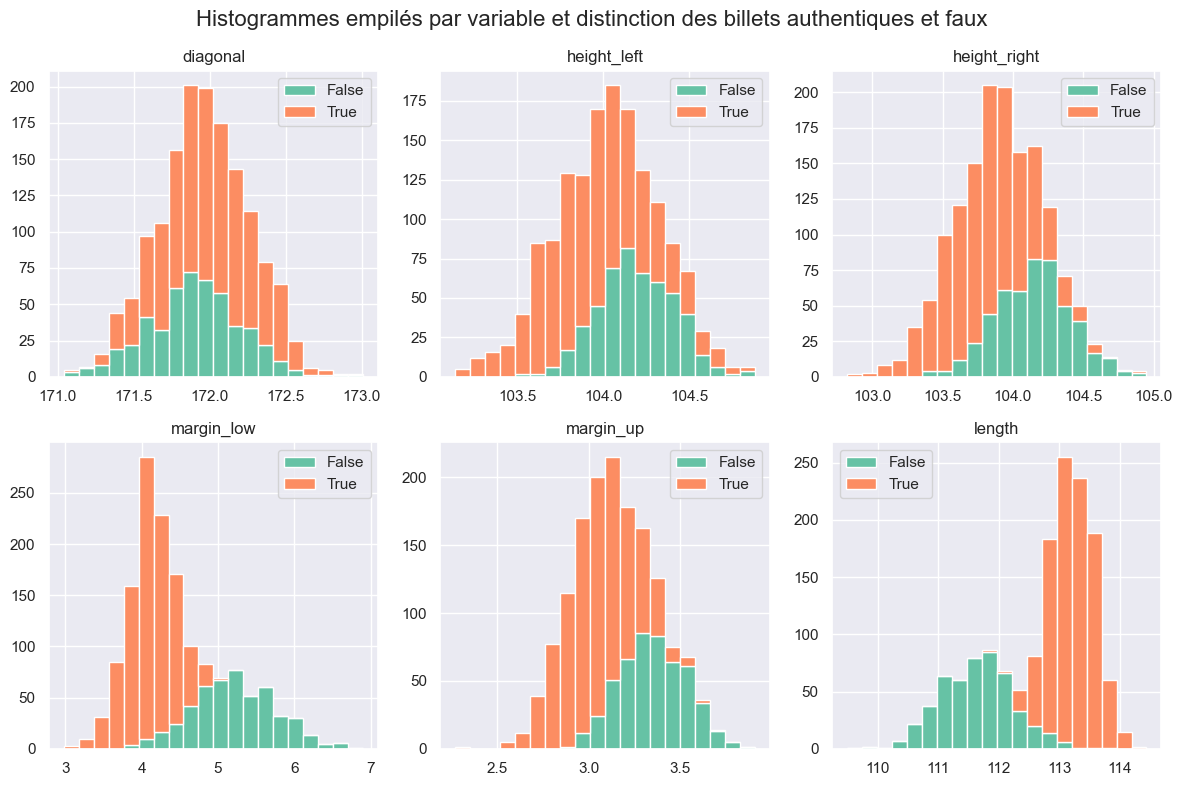

In [61]:
# Répartition des valeurs de chacune des variables et distinction selon la valeur True et False de la variable 'is_genuine'

columns = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

for i, column in enumerate(columns):
    # Obtention des valeurs pour chaque catégorie de 'is_genuine'
    values_false = billets[billets['is_genuine'] == False][column]
    values_true = billets[billets['is_genuine'] == True][column]    

    # Création des histogrammes empilés dans le sous-plot correspondant
    row_idx = i // 3
    col_idx = i % 3
    axes[row_idx, col_idx].hist([values_false, values_true], bins=20, stacked=True, label=['False', 'True'])

    # Titre pour chaque sous-plot
    axes[row_idx, col_idx].set_title(column)

    # Légende
    axes[row_idx, col_idx].legend()

# Titre de la figure
plt.suptitle("Histogrammes empilés par variable et distinction des billets authentiques et faux", fontsize=16)

# On ajuste l'espacement entre les sous-graphiques
plt.tight_layout()

plt.show()

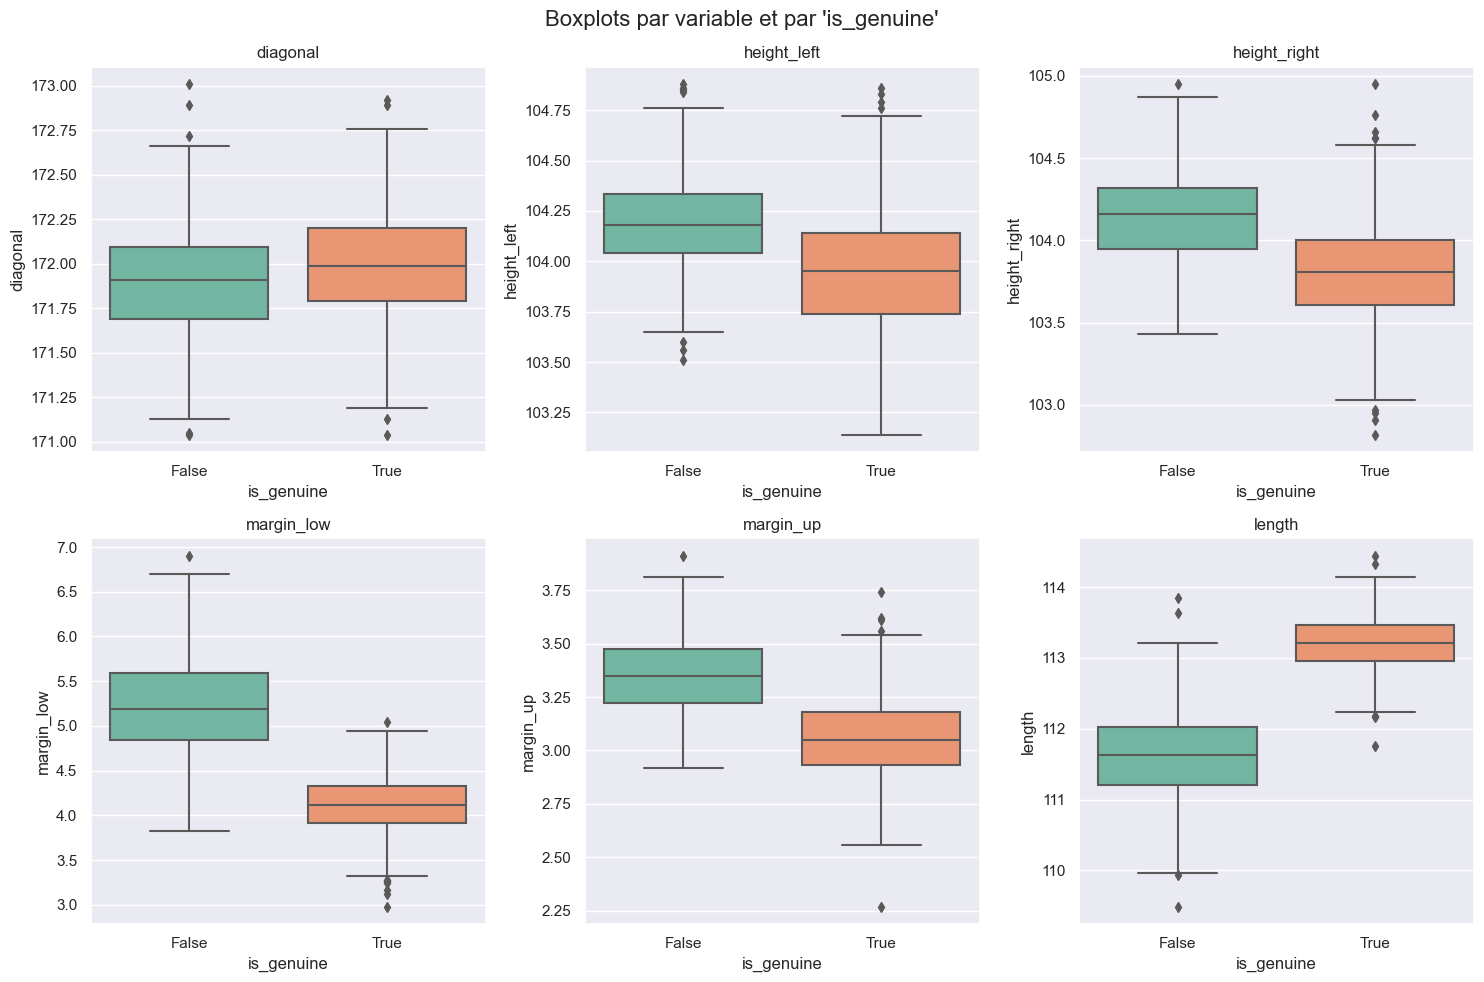

In [62]:
# Répartition des valeurs sous forme de boxplot avec la distinction True/False

columns = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']

# Grille de sous-graphiques (2 lignes, 3 colonnes)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# On parcourt les colonnes pour créer les boxplots
for i, column in enumerate(columns):
    # Création du boxplot dans le sous-plot correspondant
    row_idx = i // 3
    col_idx = i % 3
    sns.boxplot(data=billets, x='is_genuine', y=column, ax=axes[row_idx, col_idx])

    # Ajout d'un titre pour chaque sous-plot
    axes[row_idx, col_idx].set_title(column)

# Titre de la figure
plt.suptitle("Boxplots par variable et par 'is_genuine'", fontsize=16)

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()

plt.show()

In [63]:
# Somme des dimensions des billets

billets['total_dimensions'] = (billets['diagonal'] 
                               + billets['height_left']
                               + billets['height_right']
                               + billets['margin_low']
                               + billets['margin_up']
                               + billets['length']
                              )
                    
billets   

diagonal  height_left  height_right  margin_low  margin_up  length  \
0       171.81       104.86        104.95        4.52       2.89  112.83   
1       171.46       103.36        103.66        3.77       2.99  113.09   
2       172.69       104.48        103.50        4.40       2.94  113.16   
3       171.36       103.91        103.94        3.62       3.01  113.51   
4       171.73       104.28        103.46        4.04       3.48  112.54   
...        ...          ...           ...         ...        ...     ...   
1495    171.75       104.38        104.17        4.42       3.09  111.28   
1496    172.19       104.63        104.44        5.27       3.37  110.97   
1497    171.80       104.01        104.12        5.51       3.36  111.95   
1498    172.06       104.28        104.06        5.17       3.46  112.25   
1499    171.47       104.15        103.82        4.63       3.37  112.07   

      is_genuine  total_dimensions  
0           True            501.86  
1           True            498.33  
2           True            501.17  
3           True            499.35  
4           True            499.53  
...          ...               ...  
1495       False            499.09  
1496       False            500.87  
1497       False            500.75  
1498       False            501.28  
1499       False            499.51  

[1500 rows x 8 columns]

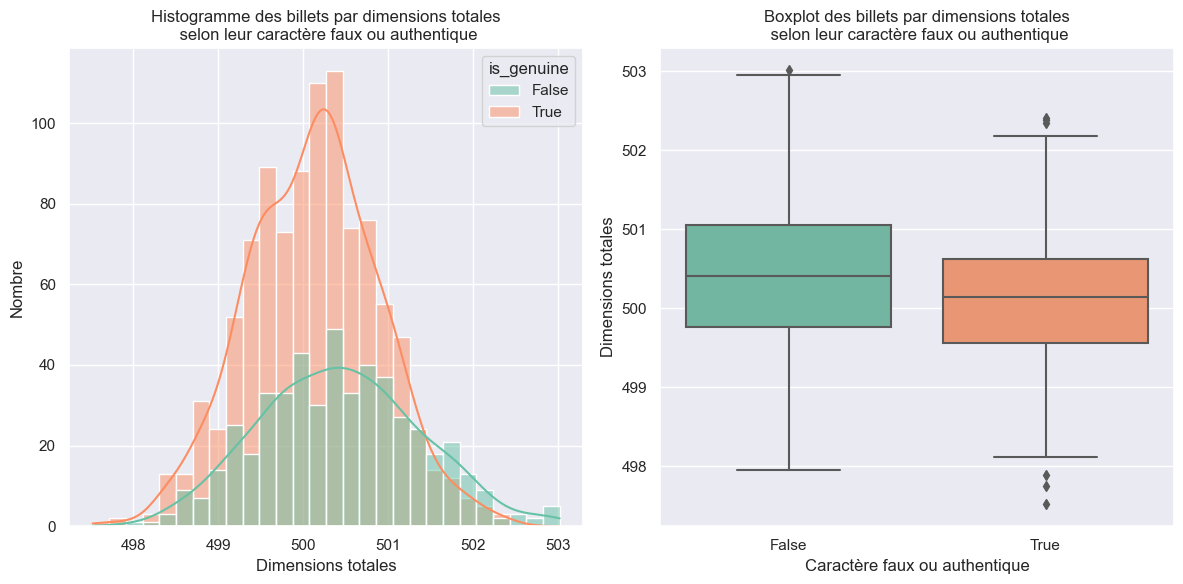

In [64]:
# Histogramme des dimensions totales

# Création d'une figure avec deux sous-graphiques (1 ligne, 2 colonnes)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Histogramme avec KDE
sns.histplot(data=billets, x='total_dimensions', hue='is_genuine', kde=True, ax=axes[0])
axes[0].set_title("Histogramme des billets par dimensions totales\n selon leur caractère faux ou authentique")
axes[0].set_ylabel("Nombre")
axes[0].set_xlabel("Dimensions totales")

# Boxplot
sns.boxplot(data=billets, x='is_genuine', y='total_dimensions', ax=axes[1])
axes[1].set_title("Boxplot des billets par dimensions totales\n selon leur caractère faux ou authentique")
axes[1].set_ylabel("Dimensions totales")
axes[1].set_xlabel("Caractère faux ou authentique")

plt.tight_layout()  # Pour éviter que les titres se chevauchent

plt.show()

In [65]:
# Suppression de la colonne total_dimensions pour le reste de l'étude
billets = billets.drop(columns = 'total_dimensions')
billets

diagonal  height_left  height_right  margin_low  margin_up  length  \
0       171.81       104.86        104.95        4.52       2.89  112.83   
1       171.46       103.36        103.66        3.77       2.99  113.09   
2       172.69       104.48        103.50        4.40       2.94  113.16   
3       171.36       103.91        103.94        3.62       3.01  113.51   
4       171.73       104.28        103.46        4.04       3.48  112.54   
...        ...          ...           ...         ...        ...     ...   
1495    171.75       104.38        104.17        4.42       3.09  111.28   
1496    172.19       104.63        104.44        5.27       3.37  110.97   
1497    171.80       104.01        104.12        5.51       3.36  111.95   
1498    172.06       104.28        104.06        5.17       3.46  112.25   
1499    171.47       104.15        103.82        4.63       3.37  112.07   

      is_genuine  
0           True  
1           True  
2           True  
3           True  
4           True  
...          ...  
1495       False  
1496       False  
1497       False  
1498       False  
1499       False  

[1500 rows x 7 columns]

# 3. Analyse en composantes principales

In [66]:
# Mise en index de la colonne is_genuine
billetsACP = billets.set_index('is_genuine', drop=True)

billetsACP

diagonal  height_left  height_right  margin_low  margin_up  length
is_genuine                                                                    
True          171.81       104.86        104.95        4.52       2.89  112.83
True          171.46       103.36        103.66        3.77       2.99  113.09
True          172.69       104.48        103.50        4.40       2.94  113.16
True          171.36       103.91        103.94        3.62       3.01  113.51
True          171.73       104.28        103.46        4.04       3.48  112.54
...              ...          ...           ...         ...        ...     ...
False         171.75       104.38        104.17        4.42       3.09  111.28
False         172.19       104.63        104.44        5.27       3.37  110.97
False         171.80       104.01        104.12        5.51       3.36  111.95
False         172.06       104.28        104.06        5.17       3.46  112.25
False         171.47       104.15        103.82        4.63       3.37  112.07

[1500 rows x 6 columns]

In [67]:
# Récolte des variables géométriques dans un df X
X = billets.drop('is_genuine', axis=1)
X[:5]

diagonal  height_left  height_right  margin_low  margin_up  length
0    171.81       104.86        104.95        4.52       2.89  112.83
1    171.46       103.36        103.66        3.77       2.99  113.09
2    172.69       104.48        103.50        4.40       2.94  113.16
3    171.36       103.91        103.94        3.62       3.01  113.51
4    171.73       104.28        103.46        4.04       3.48  112.54

In [68]:
# On stocke les noms de colonne dans une variable
features = billetsACP.columns
features

Index(['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up',
       'length'],
      dtype='object')

In [69]:
# On instancie le scaler

scaler = StandardScaler()

# adapte le scaler aux données de X

scaler.fit(X)

# Transformation des données

X_scaled = scaler.transform(X)
print('X_scaled:',X_scaled[:5])
print('____________________')
idx = ["mean", "std"]
print("Varification de la moyenne et de l'écart-type de chaque variable")
print(pd.DataFrame(X_scaled).describe().round(2).loc[idx, :])

X_scaled: [[-0.48653957  2.77412327  3.16324041  0.05625511 -1.128325    0.17365114]
 [-1.63372936 -2.23653528 -0.79966777 -1.08080039 -0.69679916  0.47166629]
 [ 2.3978233   1.50475644 -1.29119126 -0.12567377 -0.91256208  0.55190114]
 [-1.96149786 -0.39929381  0.06049835 -1.3082115  -0.61049399  0.95307539]
 [-0.74875438  0.83666863 -1.41407214 -0.67146041  1.41767746 -0.15875038]]
____________________
Varification de la moyenne et de l'écart-type de chaque variable
        0    1    2    3    4    5
mean -0.0  0.0 -0.0  0.0 -0.0  0.0
std   1.0  1.0  1.0  1.0  1.0  1.0


In [70]:
# Choix du nombre de composantes principales

n_components = 6

# On instancie l'ACP

pca = PCA(n_components=n_components)

# On l'entraîne sur les données scalées

pca.fit(X_scaled)

PCA(n_components=6)

In [71]:
# Explication de la variance des composantes principales

pca.explained_variance_ratio_

array([0.43220121, 0.16957823, 0.13021124, 0.11826529, 0.09647908,
       0.05326494])

In [72]:
# On enregistre les valeurs dans une variable scree
scree = (pca.explained_variance_ratio_*100).round(2)
print('scree:', scree)

# On calcule la somme cummulée des variances
scree_cum = scree.cumsum().round()
print('scree_cum:', scree_cum)

scree: [43.22 16.96 13.02 11.83  9.65  5.33]
scree_cum: [ 43.  60.  73.  85.  95. 100.]


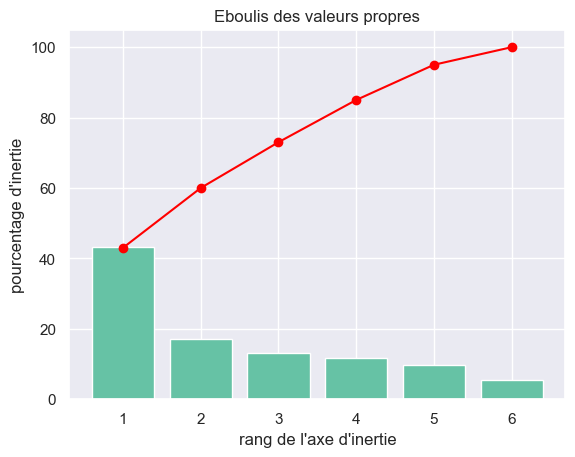

In [73]:
# Création d'une variable avec la liste des composantes
x_list = range(1, n_components+1)

# Création du graphique de l'éboulis des valeurs propres
plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

In [74]:
# Composition des composantes principales selon le poids des variables initiales
pcs = pca.components_
pcs = pd.DataFrame(pcs)

# On ajoute les noms des colonnes
pcs.columns = features
pcs.index = [f"F{i}" for i in x_list]
pcs.T.round(2)

F1    F2    F3    F4    F5    F6
diagonal     -0.08  0.94 -0.29 -0.10 -0.12  0.01
height_left   0.33  0.31  0.88 -0.05  0.10  0.01
height_right  0.39  0.11 -0.16  0.87  0.23  0.00
margin_low    0.51 -0.07 -0.11 -0.09 -0.57  0.63
margin_up     0.44 -0.00 -0.27 -0.44  0.71  0.18
length       -0.53  0.05  0.15  0.18  0.30  0.76

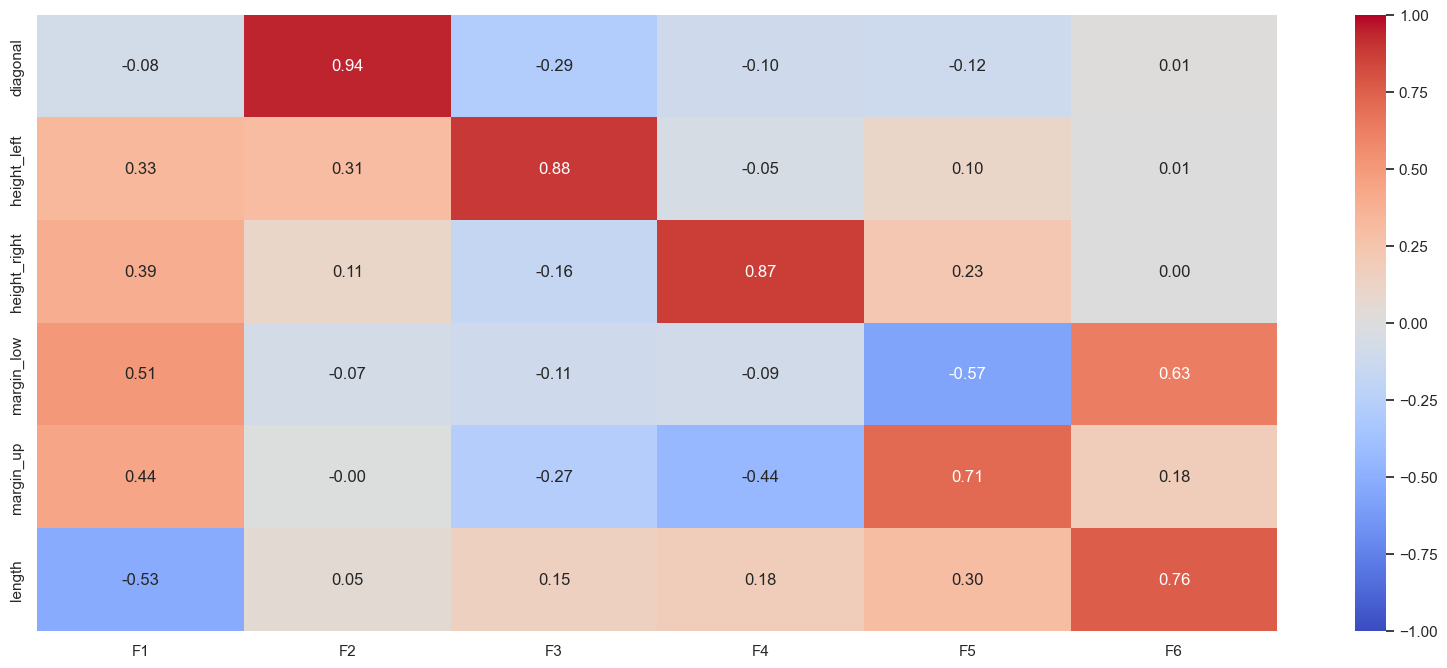

In [75]:
# Visualisation via une heatmap

fig, ax = plt.subplots(figsize=(20, 8))
sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")

plt.show()

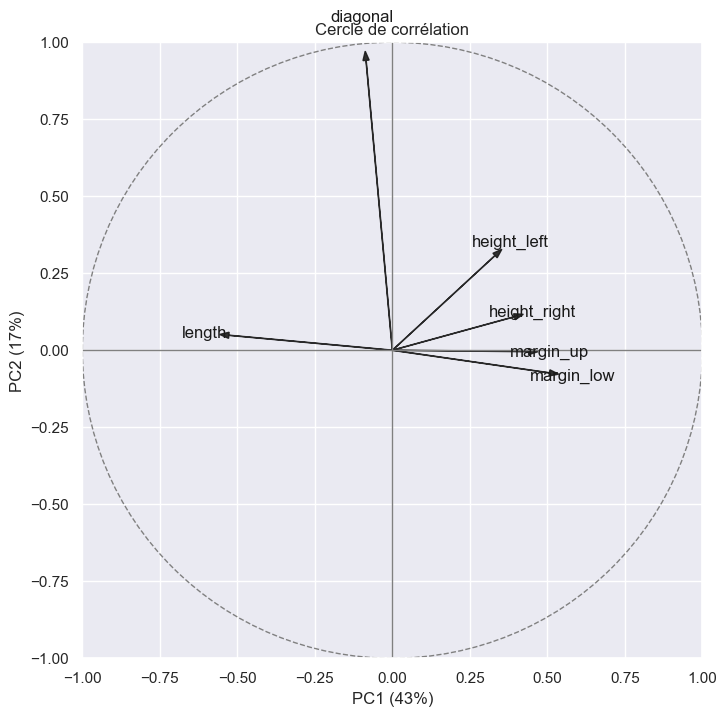

In [76]:
# Créer le cercle de corrélation
coeff = np.transpose(pca.components_[0:2, :])
n = coeff.shape[0]
xs = np.array([1, 0])
ys = np.array([0, 1])

# Créer la figure
plt.figure(figsize=(8, 8))

# Placer les vecteurs des variables
for i in range(n):
    plt.arrow(0, 0, coeff[i, 0], coeff[i, 1], color='k', alpha=0.9, head_width=0.02)
    plt.text(coeff[i, 0] * 1.15, coeff[i, 1] * 1.15, features[i], color='k', ha='center', va='center')

# Placer le cercle unitaire
circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--')
plt.gca().add_artist(circle)

# Ajuster les limites et les axes
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)
plt.xlabel('PC1 (43%)')
plt.ylabel('PC2 (17%)')
plt.title('Cercle de corrélation')

# Afficher la figure
plt.show()

In [77]:
# Mise en place de notre acp

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=3)
pca.fit(X_scaled)

PCA(n_components=3)

In [78]:
X_proj = pca.transform(X_scaled)
X_proj = pd.DataFrame(X_proj, columns = ["PC1", "PC2", "PC3"])
X_proj[:10]

PC1       PC2       PC3
0  1.646219  0.748668  2.399309
1 -2.019482 -2.207089 -1.001814
2 -0.969338  2.619082  1.198314
3 -1.375861 -1.817308  0.649379
4  0.150507 -0.565994  0.852322
5 -0.695971  0.426775 -0.867241
6  0.176177  1.302579  0.000552
7 -1.151333 -0.382728 -0.381784
8 -0.854068  1.443334 -0.686190
9 -0.596902  1.743373 -0.323489

In [79]:
is_genuine = billetsACP.index
is_genuine

Index([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
       ...
       False, False, False, False, False, False, False, False, False, False],
      dtype='bool', name='is_genuine', length=1500)

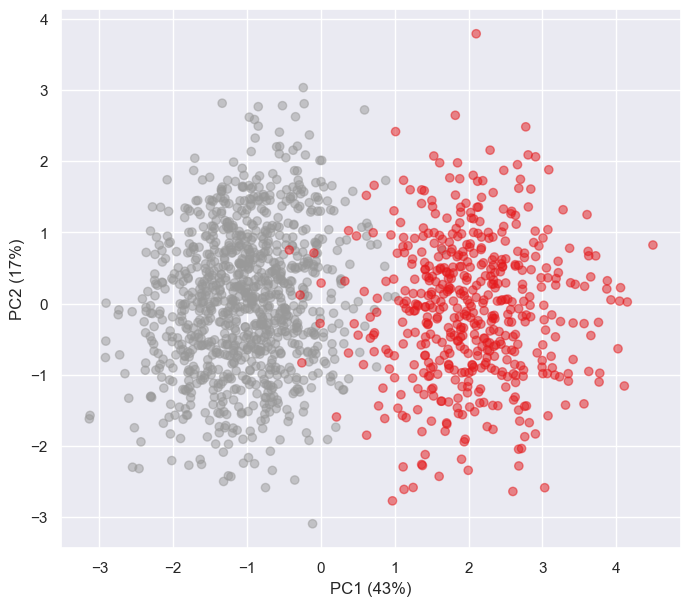

In [80]:
fig, ax = plt.subplots(1,1, figsize=(8,7))
ax.scatter(X_proj.iloc[:, 0], X_proj.iloc[:, 1], c= is_genuine, cmap="Set1", alpha =0.5)
ax.set_xlabel("PC1 (43%)")
ax.set_ylabel("PC2 (17%)")
plt.show()

In [81]:
# Ajout de la colonne is_genuine dans le but de trouver les centroïdes des clusters
X_proj['is_genuine'] = is_genuine
X_proj

PC1       PC2       PC3  is_genuine
0     1.646219  0.748668  2.399309        True
1    -2.019482 -2.207089 -1.001814        True
2    -0.969338  2.619082  1.198314        True
3    -1.375861 -1.817308  0.649379        True
4     0.150507 -0.565994  0.852322        True
...        ...       ...       ...         ...
1495  1.428239 -0.269222  0.948112       False
1496  3.280349  1.318001  0.616539       False
1497  1.888998 -0.600928 -0.545871       False
1498  1.789822  0.511074  0.027398       False
1499  1.043226 -1.470994  0.482857       False

[1500 rows x 4 columns]

In [82]:
# Calcul des positions des centroïdes
centroids = X_proj.groupby('is_genuine').mean()
centroids

PC1       PC2       PC3
is_genuine                             
False       2.03762 -0.080610 -0.115521
True       -1.01881  0.040305  0.057761

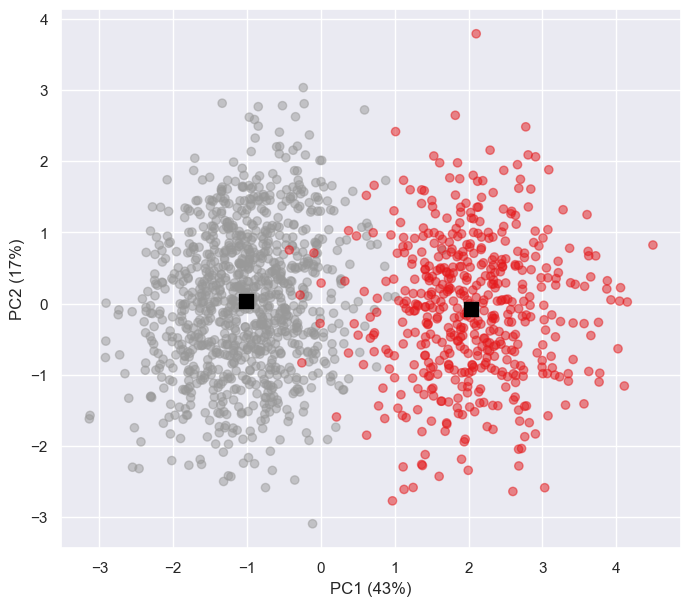

In [83]:
# Projection des individus avec leurs centroïdes
fig, ax = plt.subplots(1,1, figsize=(8,7))
ax.scatter(X_proj.iloc[:, 0], X_proj.iloc[:, 1], c= is_genuine, cmap="Set1", alpha =0.5)
ax.scatter(centroids.iloc[:, 0], centroids.iloc[:, 1], c='black', marker='s', s=100, label='Centroids')
ax.set_xlabel("PC1 (43%)")
ax.set_ylabel("PC2 (17%)")
plt.show()

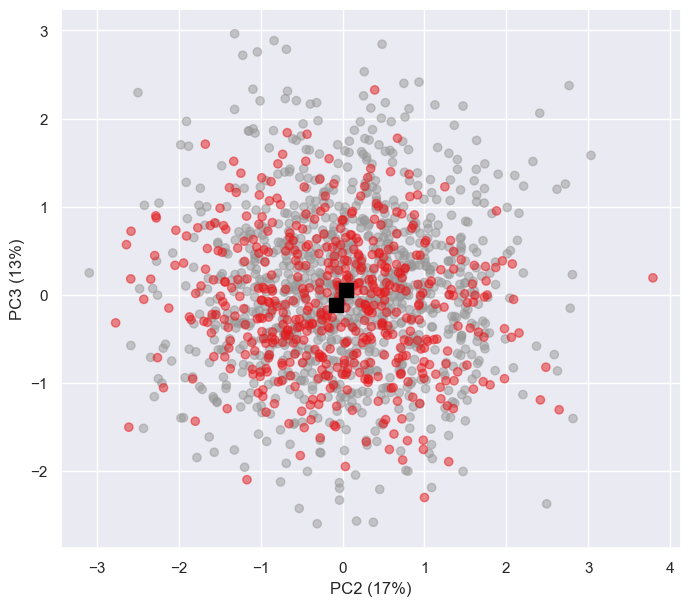

In [84]:
# Projection des individus avec leurs centroïdes
fig, ax = plt.subplots(1,1, figsize=(8,7))
ax.scatter(X_proj.iloc[:, 1], X_proj.iloc[:, 2], c= is_genuine, cmap="Set1", alpha =0.5)
ax.scatter(centroids.iloc[:, 1], centroids.iloc[:, 2], c='black', marker='s', s=100, label='Centroids')
ax.set_xlabel("PC2 (17%)")
ax.set_ylabel("PC3 (13%)")
plt.show()

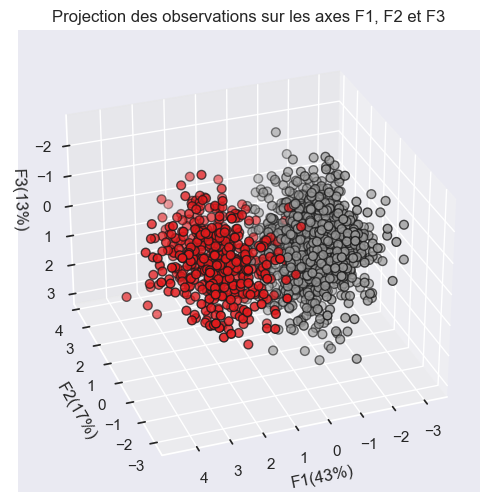

In [85]:
# On définit notre figure et notre axe : 
fig= plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)

# On affiche nos points : 
ax.scatter(
    X_proj.iloc[:, 0],
    X_proj.iloc[:, 1],
    X_proj.iloc[:, 2],
    c=is_genuine, cmap="Set1", edgecolor="k", s=40)

# On spécifie le nom des axes : 
ax.set_xlabel("F1(43%)")
ax.set_ylabel("F2(17%)")
ax.set_zlabel("F3(13%)")
ax.set_title("Projection des observations sur les axes F1, F2 et F3")
plt.show()

# 4. PREDICTIONS PAR LA METHODE DU K-MEANS

# 4.1 Recherche du nombre de cluster optimal

C:\Users\sebhe\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


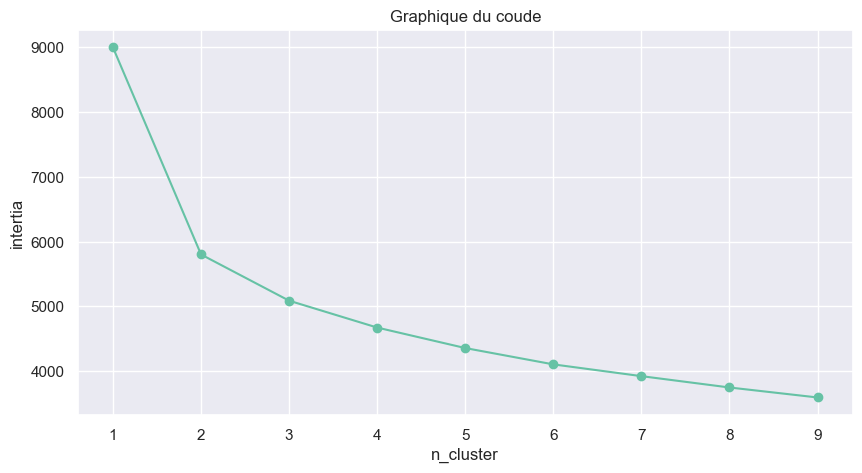

In [86]:
# Détermination du nombre de clusters à choisir avec la méthode du coude

X = billets.drop('is_genuine', axis=1)

from sklearn.preprocessing import StandardScaler
# Normalisation des données
std_scaler = StandardScaler()
X = std_scaler.fit_transform(X)

# Liste vide pour enregistrer les inerties :
inertia_list = []

# Liste de nombres de clusters :
k_list = range(1, 10)

# Pour chaque nombre de clusters :
for k in k_list:
    # On instancie un k-means pour k clusters
    kmeans = KMeans(n_clusters=k)

    # On entraine
    kmeans.fit(X)

    # On enregistre l'inertie obtenue :
    inertia_list.append(kmeans.inertia_)

# Représentation graphique
fig, ax = plt.subplots(1,1,figsize=(10,5))

ax.set_ylabel("intertia")
ax.set_xlabel("n_cluster")
ax.set_title('Graphique du coude')

ax = plt.plot(k_list, inertia_list, marker = 'o')
plt.show()

Le nombre de clusters optimal est donc de 2, ce qui est tout à fait cohérent avec le caractère authentique ou faux des billets observés.

# 4.2.Entraînement de l'algorithme et résultats

In [87]:
# Séparation des variables indépendante de la variable dépendante is_genuine

X = billets.drop('is_genuine', axis = 1)
y = billets[['is_genuine']]

from sklearn.preprocessing import StandardScaler
# Normalisation des données
std_scaler = StandardScaler()
X = std_scaler.fit_transform(X)

# Séparation des données en données d'entraînement et données test 80/20

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('train set :', X_train.shape)
print('test set :', X_test.shape)

train set : (1200, 6)
test set : (300, 6)


In [128]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(X_train)
kmeans.score(X_train)

-777.6528174210483

In [89]:
kmeans.score(X_test)

-1115.0018457127628

In [129]:
y_pred = kmeans.predict(X_test)
y_pred

array([0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1])

In [91]:
y_test

is_genuine
1116       False
1368       False
422         True
413         True
451         True
...          ...
983         True
799         True
1265       False
1150       False
824         True

[300 rows x 1 columns]

In [92]:
y_test['is_genuine'] = y_test['is_genuine'].replace({True: 1, False: 0})
y_test

is_genuine
1116           0
1368           0
422            1
413            1
451            1
...          ...
983            1
799            1
1265           0
1150           0
824            1

[300 rows x 1 columns]

In [130]:
# Calcul de la précision du modèle
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test['is_genuine'], y_pred)
print(f"Précision du modèle KMeans : {accuracy:.4f}")

Précision du modèle KMeans : 0.9800


### Matrice de confusion y_test/y_pred

In [131]:
# Matrice de confusion
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
print(cm)

[[104   6]
 [  0 190]]


### Rapport de classification y_test/y_pred

In [132]:
from sklearn.metrics import classification_report

# Générer le rapport de classification
report = classification_report(y_test, y_pred)

# Afficher le rapport de classification
print(report)

              precision    recall  f1-score   support

       False       1.00      0.95      0.97       110
        True       0.97      1.00      0.98       190

    accuracy                           0.98       300
   macro avg       0.98      0.97      0.98       300
weighted avg       0.98      0.98      0.98       300



# 4.3 Représentation graphique en 2 dimensions via l'ACP

In [96]:
# On instancie notre Kmeans avec 2 clusters : 
kmeans = KMeans(n_clusters=2)

# On l'entraine : 
kmeans.fit(X)

# On peut stocker nos clusters dans une variable labels : 
labels = kmeans.labels_
print('labels :')
print(labels)
print('---------------------')

# On peut stocker nos centroids dans une variable : 
centroids = kmeans.cluster_centers_
print('centroïdes :')
print(centroids)

labels :
[1 0 0 ... 1 1 1]
---------------------
centroïdes :
[[ 0.09600039 -0.28194592 -0.35241933 -0.55346247 -0.42692359  0.59324013]
 [-0.19432338  0.57071311  0.71336493  1.12031516  0.86417597 -1.20083284]]


In [97]:
# Mise en place de notre acp

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
pca.fit(X_scaled)

PCA(n_components=2)

In [98]:
# Nous allons projeter les individus sur les axes principaux d'inertie grâce à l'ACP

X_proj = pca.transform(X_scaled)
X_proj = pd.DataFrame(X_proj, columns = ["PC1", "PC2"])
X_proj[:10]

PC1       PC2
0  1.646219  0.748668
1 -2.019482 -2.207089
2 -0.969338  2.619082
3 -1.375861 -1.817308
4  0.150507 -0.565994
5 -0.695971  0.426775
6  0.176177  1.302579
7 -1.151333 -0.382728
8 -0.854068  1.443334
9 -0.596902  1.743373

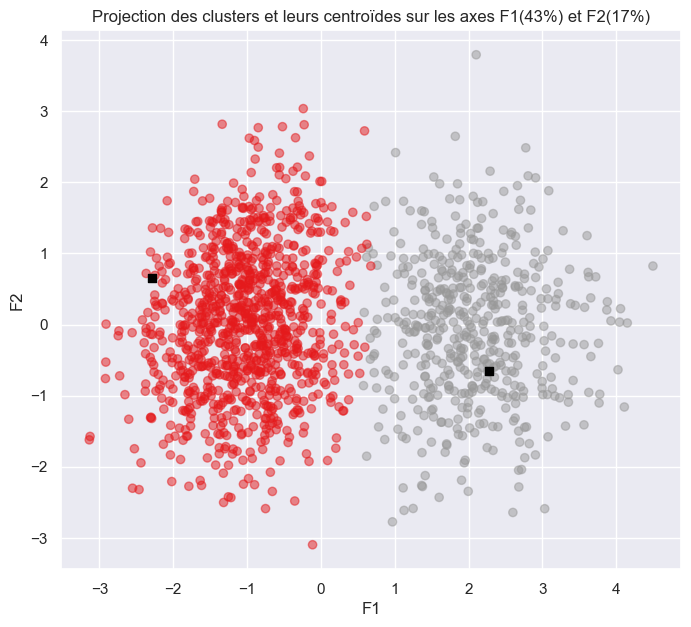

In [99]:
# On utilise le scaler déjà entrainé : 
centroids_scaled = scaler.fit_transform(centroids)

# et on utilise l'ACP déjà entrainée : 
centroids_proj = pca.transform(centroids_scaled)

# Création d'un dataframe pour plus de clarté:
centroids_proj = pd.DataFrame(centroids_proj, 
                              columns = ["F1", "F2"], 
                              index=["cluster_0", "cluster_1"])

# On définit notre figure et son axe : 
fig, ax = plt.subplots(1,1, figsize=(8,7))

# On affiche nos individus, avec une transparence de 50% (alpha=0.5) : 
ax.scatter(X_proj.iloc[:, 0], X_proj.iloc[:, 1], c= labels, cmap="Set1", alpha =0.5)

# On affiche nos centroides, avec une couleur noire (c="black") et une frome de carré (marker="s") : 
ax.scatter(centroids_proj.iloc[:, 0], centroids_proj.iloc[:, 1],  marker="s", c="black" )

# On spécifie les axes x et y :
ax.set_xlabel("F1")
ax.set_ylabel("F2")
ax.set_title("Projection des clusters et leurs centroïdes sur les axes F1(43%) et F2(17%)")

plt.show()

# 5. PREDICTIONS PAR LA REGRESSION LOGISTIQUE

In [100]:
# Séparation des variables indépendantes de la variable dépendante is_genuine

X = billets.drop('is_genuine', axis = 1)
y = billets[['is_genuine']]

# Séparation des données en données d'entraînement et données test 80/20

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('train set :', X_train.shape)
print('test set :', X_test.shape)

train set : (1200, 6)
test set : (300, 6)


In [101]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score

# Modèle de régression logistique
logit_model = LogisticRegression(max_iter=500)

logit_model.fit(X_train, np.ravel(y_train))

# Prédiction des valeurs sur les données de test
y_pred = logit_model.predict(X_test)

# Validation croisée avec 5 plis
cv_scores = cross_val_score(logit_model, X_train, np.ravel(y_train), cv=5, scoring='roc_auc')
print("Scores de validation croisée (Train) :", cv_scores)

# Score moyen de la validation croisée
print("Score moyen de validation croisée (Train) :", cv_scores.mean())

# Calculer le score ROC AUC
roc_auc = roc_auc_score(y_test, y_pred)

# Afficher le score ROC AUC
print("Score (Test) :", roc_auc)

Scores de validation croisée (Train) : [0.99968344 0.99952517 0.99952517 0.99176955 0.99952517]
Score moyen de validation croisée (Train) : 0.998005698005698
Score (Test) : 0.9863636363636364


### Courbes ROC y_train/y_test

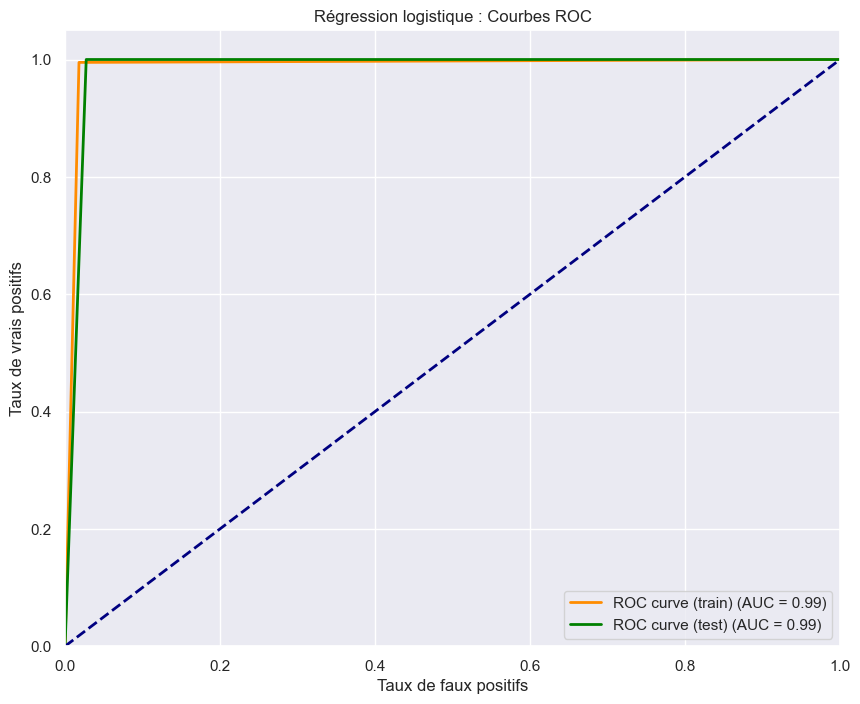

In [102]:
from sklearn.metrics import roc_curve, auc
# Obtenir les prédictions du modèle sur l'ensemble d'entraînement et de test
y_train_pred = logit_model.predict(X_train)
y_test_pred = logit_model.predict(X_test)

# Calculer les courbes ROC et les aires sous la courbe (AUC)
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_pred)
roc_auc_test = auc(fpr_test, tpr_test)

# Tracer les courbes ROC
plt.figure(figsize=(10, 8))
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label='ROC curve (train) (AUC = %0.2f)' % roc_auc_train)
plt.plot(fpr_test, tpr_test, color='green', lw=2, label='ROC curve (test) (AUC = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Régression logistique : Courbes ROC')
plt.legend(loc="lower right")
plt.show()

### Coefficients des variables

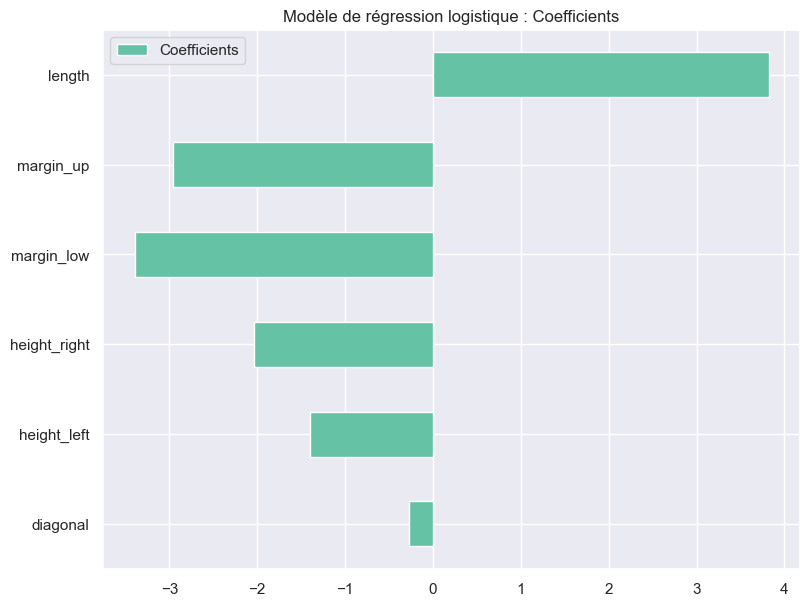

In [103]:
# Représentation graphique de l'impact des variables sur le modèle
coefs = pd.DataFrame(logit_model.coef_.T, columns=["Coefficients"], index=X_train.columns)

coefs.plot(kind="barh", figsize=(9, 7))
plt.title("Modèle de régression logistique : Coefficients")
plt.show()

### Rapport de classification y_train_pred/y_train

In [104]:
# Prédire les classes sur la base de test
y_train_pred = logit_model.predict(X_train) > 0.5

# Générer le rapport de classification
report = classification_report(y_train, y_train_pred)

# Afficher le rapport de classification
print(report)

              precision    recall  f1-score   support

       False       0.99      0.98      0.99       390
        True       0.99      1.00      0.99       810

    accuracy                           0.99      1200
   macro avg       0.99      0.99      0.99      1200
weighted avg       0.99      0.99      0.99      1200



### Matrice de confusion y_train_pred/y_train

In [105]:
# Matrice de confusion
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_train, y_train_pred)
print(confusion_matrix)

[[383   7]
 [  4 806]]


### Rapport de classification y_test_pred/y_test

In [106]:
from sklearn.metrics import classification_report

# Prédire les classes sur la base de test
y_test_pred = logit_model.predict(X_test) > 0.5

# Générer le rapport de classification
report = classification_report(y_test, y_test_pred)

# Afficher le rapport de classification
print(report)

              precision    recall  f1-score   support

       False       1.00      0.97      0.99       110
        True       0.98      1.00      0.99       190

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



### Matrice de confusion y_test_pred/y_test

In [107]:
# Matrice de confusion
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test, y_test_pred)
print(confusion_matrix)

[[107   3]
 [  0 190]]


# 6. PREDICTIONS PAR LA METHODE DU SVM

In [108]:
# Séparation des variables indépendantes de la variable dépendante is_genuine

X = billets.drop('is_genuine', axis = 1)
y = billets[['is_genuine']]


# Séparation des données en données d'entraînement et données test 80/20

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('train set :', X_train.shape)
print('test set :', X_test.shape)

train set : (1200, 6)
test set : (300, 6)


In [109]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

# Normalisation des données
std_scaler = StandardScaler()
X_train = std_scaler.fit_transform(X_train)
X_test = std_scaler.transform(X_test)
# Instanciation du modèle
classifier = SVC(kernel = "poly", gamma="auto")

# Entraînement du modèle
classifier.fit(X_train, np.ravel(y_train))

# Calcul de la prédiction sur le training set
y_train_pred = classifier.predict(X_train)

# Affiche le score de précision du training set
print('TRAIN SET')
print('Classification report')
print(classification_report(y_train, y_train_pred))

print("--------------------------------------------------------")

# Affiche la matrice de confusion du training set
cm_train = confusion_matrix(y_train, y_train_pred)
print ('Confusion matrix')
print(cm_train)

TRAIN SET
Classification report
              precision    recall  f1-score   support

       False       1.00      0.96      0.98       390
        True       0.98      1.00      0.99       810

    accuracy                           0.99      1200
   macro avg       0.99      0.98      0.99      1200
weighted avg       0.99      0.99      0.99      1200

--------------------------------------------------------
Confusion matrix
[[375  15]
 [  0 810]]


In [110]:
from sklearn.metrics import confusion_matrix

# Calcul de la prédiction sur le test set
y_test_pred = classifier.predict(X_test)

# Affiche le score de précision du test set
print('TEST SET')
print('Classification report')
print(classification_report(y_test, y_test_pred))

print("--------------------------------------------------------")

# Affiche la matrice de confusion du training set
cm_train = confusion_matrix(y_test, y_test_pred)
print ('Confusion matrix')
print(cm_train)

TEST SET
Classification report
              precision    recall  f1-score   support

       False       1.00      0.92      0.96       110
        True       0.95      1.00      0.98       190

    accuracy                           0.97       300
   macro avg       0.98      0.96      0.97       300
weighted avg       0.97      0.97      0.97       300

--------------------------------------------------------
Confusion matrix
[[101   9]
 [  0 190]]


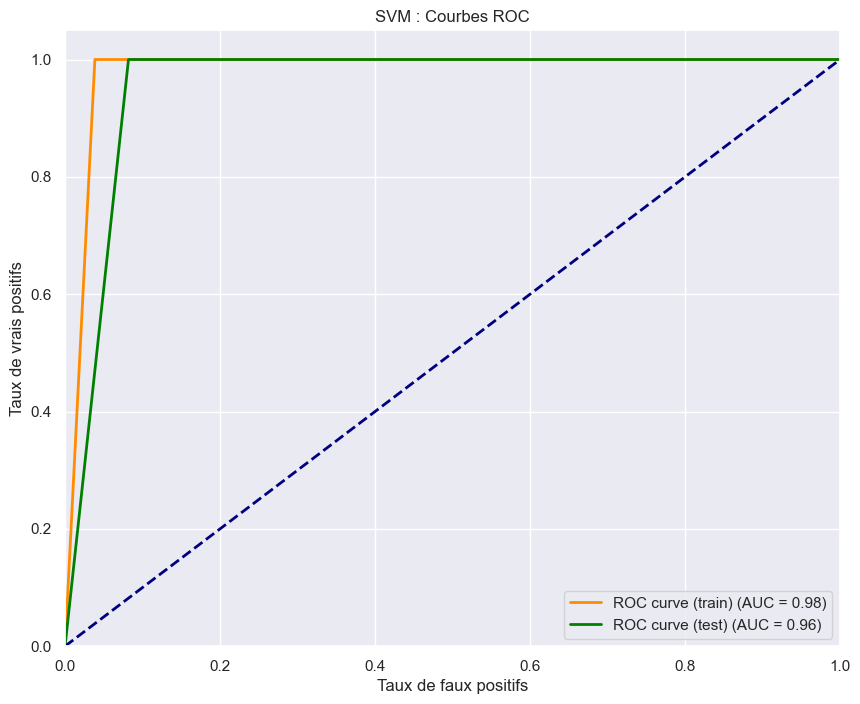

In [111]:
from sklearn.metrics import roc_curve, auc

# Calcul des courbes ROC et des aires sous la courbe (AUC)
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred)
roc_auc_train = auc(fpr_train, tpr_train)

# Calcul des taux de faux positifs (FPR) et de vrais positifs (TPR)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_pred)
roc_auc_test = auc(fpr_test, tpr_test)

# Courbes ROC
plt.figure(figsize=(10, 8))
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label='ROC curve (train) (AUC = %0.2f)' % roc_auc_train)
plt.plot(fpr_test, tpr_test, color='green', lw=2, label='ROC curve (test) (AUC = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('SVM : Courbes ROC')
plt.legend(loc="lower right")
plt.show()

# 7. PREDICTION PAR LA METHODE DE LA FORÊT ALEATOIRE

In [112]:
# Séparation des variables indépendante de la variable dépendante is_genuine

X = billets.drop('is_genuine', axis = 1)
y = billets[['is_genuine']]


# Séparation des données en données d'entraînement et données test 80/20

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('train set :', X_train.shape)
print('test set :', X_test.shape)

train set : (1200, 6)
test set : (300, 6)


In [113]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler


# Instancier le modèle de forêt aléatoire
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Entraîner le modèle sur l'ensemble d'entraînement
rf_model.fit(X_train, np.ravel(y_train))

# Prédire les classes sur l'ensemble d'entraînement
y_train_pred = rf_model.predict(X_train)

# Afficher le rapport de classification pour l'ensemble d'entraînement
print("TRAIN SET")
print("Classification report")
print(classification_report(y_train, y_train_pred))

print("--------------------------------------------------------")

# Afficher la matrice de confusion pour l'ensemble d'entraînement
cm_train = confusion_matrix(y_train, y_train_pred)
print("Confusion matrix")
print(cm_train)


TRAIN SET
Classification report
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       390
        True       1.00      1.00      1.00       810

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      1.00      1.00      1200

--------------------------------------------------------
Confusion matrix
[[390   0]
 [  0 810]]


In [114]:
# Prédire les classes sur l'ensemble test
y_test_pred = rf_model.predict(X_test)

# Afficher le rapport de classification pour l'ensemble d'entraînement
print("TEST SET")
print("Classification report")
print(classification_report(y_test, y_test_pred))

print("--------------------------------------------------------")

# Afficher la matrice de confusion pour l'ensemble d'entraînement
cm_train = confusion_matrix(y_test, y_test_pred)
print("Confusion matrix")
print(cm_train)

TEST SET
Classification report
              precision    recall  f1-score   support

       False       1.00      0.97      0.99       110
        True       0.98      1.00      0.99       190

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300

--------------------------------------------------------
Confusion matrix
[[107   3]
 [  0 190]]


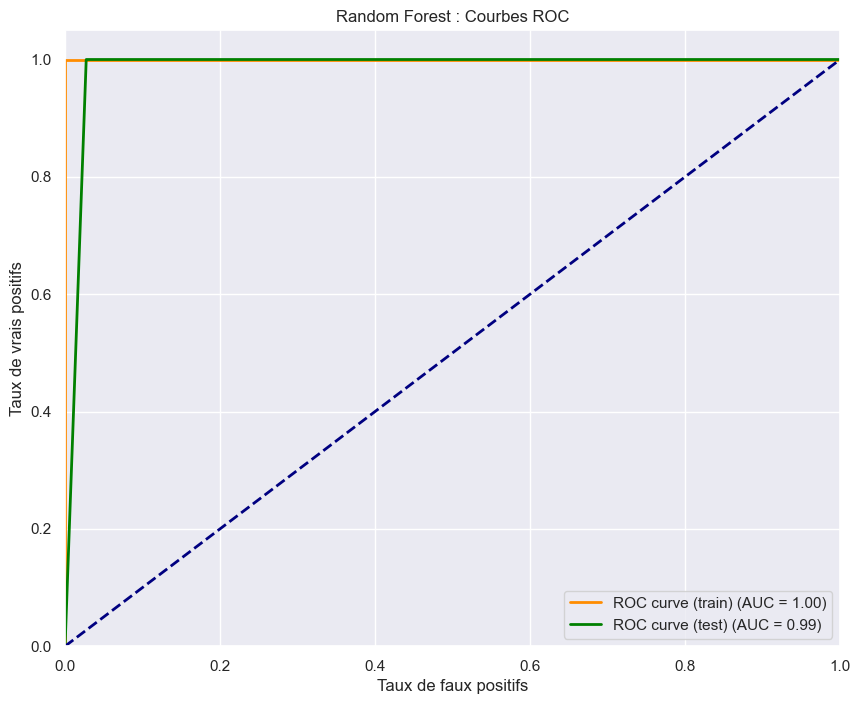

In [115]:
from sklearn.metrics import roc_curve, auc

# Calcul des courbes ROC et des aires sous la courbe (AUC)
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred)
roc_auc_train = auc(fpr_train, tpr_train)

# Calcul des taux de faux positifs (FPR) et de vrais positifs (TPR)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_pred)
roc_auc_test = auc(fpr_test, tpr_test)

# Courbes ROC
plt.figure(figsize=(10, 8))
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label='ROC curve (train) (AUC = %0.2f)' % roc_auc_train)
plt.plot(fpr_test, tpr_test, color='green', lw=2, label='ROC curve (test) (AUC = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Random Forest : Courbes ROC')
plt.legend(loc="lower right")
plt.show()

Importance des variables :
       Variable  Importance
0        length    0.477874
1    margin_low    0.317045
2     margin_up    0.106849
3  height_right    0.049739
4   height_left    0.040168
5      diagonal    0.008326



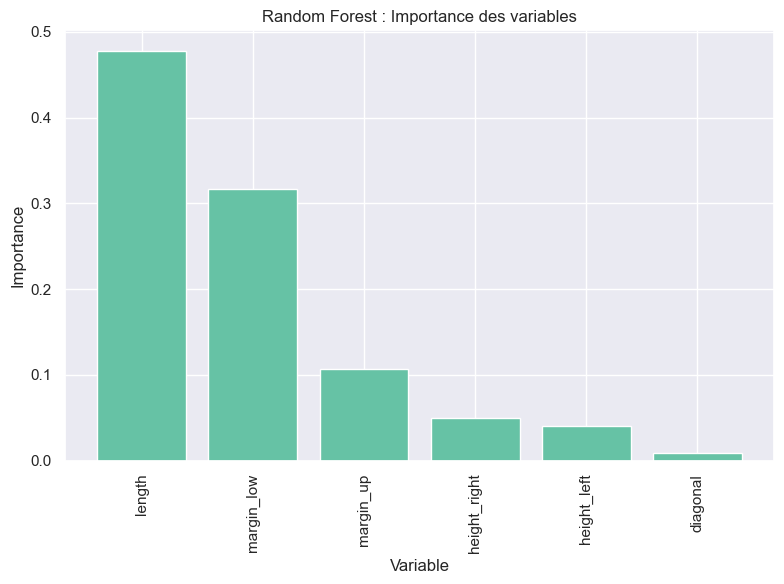

In [116]:
# Obtenir l'importance des variables
importance = rf_model.feature_importances_

# Créer un DataFrame pour afficher l'importance des variables
importance_df = pd.DataFrame({'Variable': X.columns, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Afficher l'importance des variables
print("Importance des variables :")
print(importance_df)
print()

# Tracer l'importance des variables
plt.figure(figsize=(8, 6))
plt.bar(importance_df['Variable'], importance_df['Importance'])
plt.xticks(rotation='vertical')
plt.xlabel('Variable')
plt.ylabel('Importance')
plt.title('Random Forest : Importance des variables')
plt.tight_layout()
plt.show()

# 8. ANALYSE PREDICTIVE

## 8.1 Définition d'une fonction de prédiction

In [117]:
# Sauvegarde du modèle de régression logistique
from joblib import dump, load
dump(logit_model, 'logit_model.joblib')

['logit_model.joblib']

In [118]:
# Création d'une fonction pour l'analyse prédictive
def predict_function (model, fichier_csv):
    
    # Import du fichier à tester
    billets_new = pd.read_csv(fichier_csv)

    # Collecte des variables géométriques
    columns = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']
    X = billets_new[columns]
    
    # Chargement du modèle de régression logistique
    logit_model = load(model) 

    # Prédiction de la classe des billets
    y = logit_model.predict(X)

    # Récupération des probabilités associées
    z = logit_model.predict_proba(X)

    # Création de 3 nouvelles colonnes pour afficher les résultats
    billets_new['is_genuine'] = y
    billets_new['predict_True'] = np.round(100*z[:,1],2)
    billets_new['predict_False'] = np.round(100*z[:,0],2)

    # Affichage du dataframe
    return billets_new


## 8.2 Prédiction des nouveaux billets

In [133]:
# Définition des paramètres de la focntion
fichier_csv = "billets_test.csv"
model = "logit_model.joblib"
results = predict_function (model, fichier_csv)

In [134]:
# Affichage des résultats
results

diagonal  height_left  height_right  margin_low  margin_up  length   id  \
0    172.09       103.95        103.73        4.39       3.09  113.19  B_1   
1    171.52       104.17        104.03        5.27       3.16  111.82  B_2   
2    171.78       103.80        103.75        3.81       3.24  113.39  B_3   
3    172.02       104.08        103.99        5.57       3.30  111.10  B_4   
4    171.79       104.34        104.37        5.00       3.07  111.87  B_5   

   is_genuine  predict_True  predict_False  
0        True         98.97           1.03  
1       False          0.97          99.03  
2        True         99.92           0.08  
3       False          0.02          99.98  
4       False          1.40          98.60

### Matrice de confusion

In [121]:
# Récupération de la colonne is_genuine
y_test = billets_corrigé['is_genuine']

# Matrice de confusion
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y)
print(cm)

NameError: name 'billets_corrigé' is not defined